In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#downloading the dataset with 1024 of gaussian noise
url = "https://drive.google.com/u/0/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download"
output = "data_gaussian_2048.zip"
gdown.download(url, output)
!unzip data_gaussian_2048.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download
From (redirected): https://drive.google.com/uc?id=1mTAkCy_oAodM9qcEzDTPg-QdkWQykJEQ&export=download&confirm=t&uuid=975341ac-19c7-4634-8bd1-f6bdd33eca62
To: /content/data_gaussian_2048.zip
100%|██████████| 124M/124M [00:01<00:00, 80.9MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_2048/clean/images/1_1695.png  
  inflating: data_gaussian_2048/clean/images/1_1696.png  
  inflating: data_gaussian_2048/clean/images/1_1697.png  
  inflating: data_gaussian_2048/clean/images/1_1710.png  
  inflating: data_gaussian_2048/clean/images/1_1711.png  
  inflating: data_gaussian_2048/clean/images/1_1712.png  
  inflating: data_gaussian_2048/clean/images/1_1714.png  
  inflating: data_gaussian_2048/clean/images/1_1715.png  
  inflating: data_gaussian_2048/clean/images/1_1716.png  
  inflating: data_gaussian_2048/clean/images/1_1719.png  
  inflating: data_gaussian_2048/clean/images/1_1723.png  
  inflating: data_gaussian_2048/clean/images/1_1724.png  
  inflating: data_gaussian_2048/clean/images/1_1726.png  
  inflating: data_gaussian_2048/clean/images/1_1727.png  
  inflating: data_gaussian_2048/clean/images/1_1728.png  
  inflating: data_gaussian_2048/clean/images/1_1737.png  
  inflating: data_gaus

In [30]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_2048")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_2048/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_2048/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean



 25%|██▌       | 1/4 [00:19<00:57, 19.23s/it]

clean_validation



 50%|█████     | 2/4 [00:21<00:18,  9.47s/it]

jammed_channel



 75%|███████▌  | 3/4 [00:24<00:06,  6.47s/it]

test



100%|██████████| 4/4 [00:29<00:00,  7.44s/it]


In [31]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [32]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense) 

Summary of the encoder:



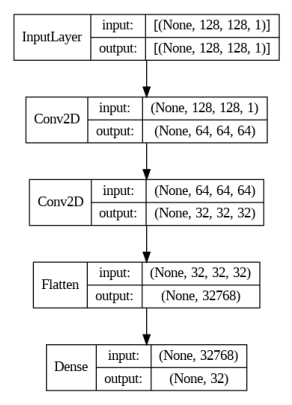

Summary of the decoder:



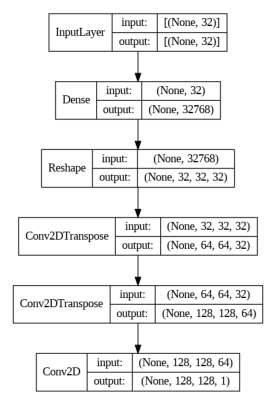

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [34]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 8s 47ms/step - loss: 0.0289 - val_loss: 0.0205
Epoch 2/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 3/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 4/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 5/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0196 - val_loss: 0.0182
Epoch 6/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0163 - val_loss: 0.0144
Epoch 7/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 8/20
125/125 [==============================] - 6s 49ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 9/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 10/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0142 - val_lo

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

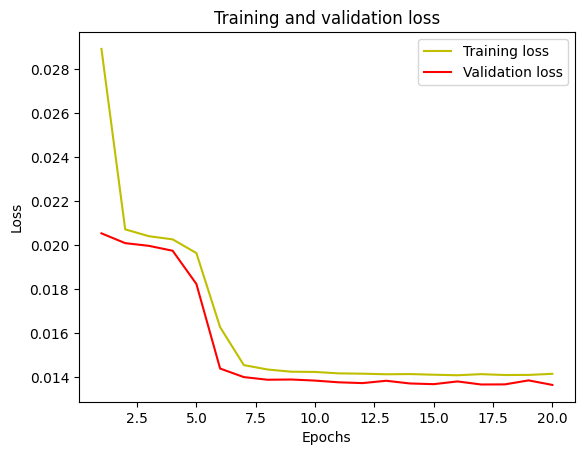

In [35]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 0s 21ms/step


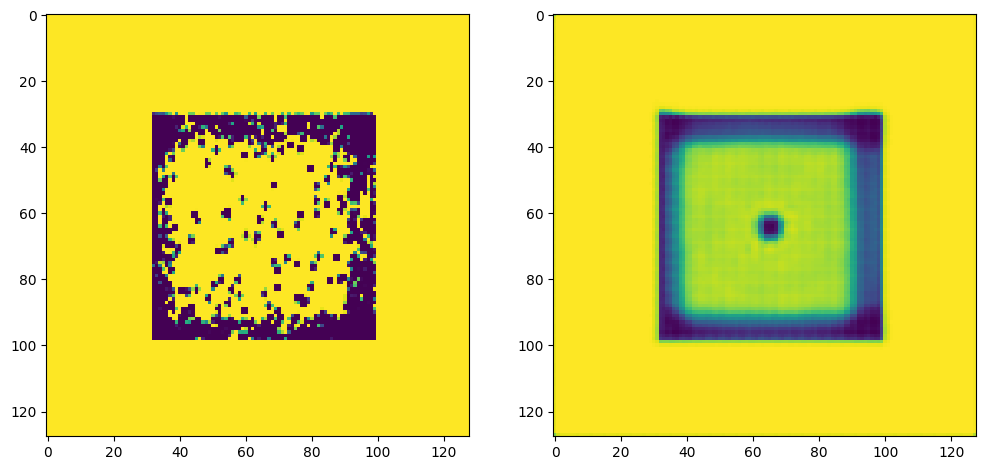

In [37]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [38]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 0s 20ms/step - loss: 0.0777
Validation error 0.013634436763823032
Anomaly error 0.07769403606653214
The reconstruction error of the jammed channel is  5.698367846971267  more than the clean channel


In [39]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [40]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


  0%|          | 2/600 [00:00<00:37, 16.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


  1%|          | 4/600 [00:00<00:43, 13.83it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0204


  1%|          | 6/600 [00:00<00:40, 14.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0080


  1%|▏         | 8/600 [00:00<00:41, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


  2%|▏         | 10/600 [00:00<00:41, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


  2%|▏         | 12/600 [00:00<00:41, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


  2%|▏         | 14/600 [00:00<00:40, 14.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


  3%|▎         | 16/600 [00:01<00:39, 14.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0202


  3%|▎         | 18/600 [00:01<00:38, 15.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


  3%|▎         | 20/600 [00:01<00:37, 15.29it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


  4%|▎         | 22/600 [00:01<00:38, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0080


  4%|▍         | 24/600 [00:01<00:39, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0196


  4%|▍         | 26/600 [00:01<00:39, 14.68it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0191


  5%|▍         | 28/600 [00:01<00:38, 14.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


  5%|▌         | 30/600 [00:02<00:37, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


  5%|▌         | 32/600 [00:02<00:37, 15.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


  6%|▌         | 34/600 [00:02<00:36, 15.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0078


  6%|▌         | 36/600 [00:02<00:37, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0213


  6%|▋         | 38/600 [00:02<00:37, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0205


  7%|▋         | 40/600 [00:02<00:36, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


  7%|▋         | 42/600 [00:02<00:36, 15.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


  7%|▋         | 44/600 [00:02<00:39, 14.13it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0072


  8%|▊         | 46/600 [00:03<00:49, 11.30it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0072


  8%|▊         | 48/600 [00:03<00:59,  9.29it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0199


  8%|▊         | 50/600 [00:03<01:04,  8.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0195


  8%|▊         | 51/600 [00:03<01:03,  8.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0190


  9%|▊         | 52/600 [00:04<01:01,  8.90it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0196


  9%|▉         | 53/600 [00:04<01:23,  6.57it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0195


  9%|▉         | 54/600 [00:04<01:18,  6.93it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0208


  9%|▉         | 55/600 [00:04<01:15,  7.21it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0072


  9%|▉         | 56/600 [00:04<01:10,  7.72it/s]

1/1 [==============================] - 0s 72ms/step - loss: 0.0078


 10%|▉         | 57/600 [00:04<01:14,  7.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0202


 10%|▉         | 58/600 [00:04<01:15,  7.13it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0180


 10%|▉         | 59/600 [00:05<01:24,  6.41it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0072


 10%|█         | 60/600 [00:05<01:35,  5.68it/s]

1/1 [==============================] - 0s 139ms/step - loss: 0.0072


 10%|█         | 61/600 [00:05<01:55,  4.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0209


 10%|█         | 62/600 [00:05<01:50,  4.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0210


 11%|█         | 64/600 [00:06<01:18,  6.81it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0209


 11%|█         | 66/600 [00:06<01:01,  8.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0203


 11%|█▏        | 68/600 [00:06<00:51, 10.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 12%|█▏        | 70/600 [00:06<00:45, 11.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0203


 12%|█▏        | 72/600 [00:06<00:47, 11.03it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0189


 12%|█▏        | 74/600 [00:06<00:47, 11.04it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0202


 13%|█▎        | 76/600 [00:07<00:48, 10.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0189


 13%|█▎        | 78/600 [00:07<00:49, 10.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0188


 13%|█▎        | 80/600 [00:07<00:49, 10.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 14%|█▎        | 82/600 [00:07<00:49, 10.45it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0072


 14%|█▍        | 84/600 [00:07<00:48, 10.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0072


 14%|█▍        | 86/600 [00:07<00:47, 10.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0224


 15%|█▍        | 88/600 [00:08<00:47, 10.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0072


 15%|█▌        | 90/600 [00:08<00:46, 10.96it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0072


 15%|█▌        | 92/600 [00:08<00:47, 10.81it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0202


 16%|█▌        | 94/600 [00:08<00:49, 10.31it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 16%|█▌        | 96/600 [00:08<00:47, 10.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 16%|█▋        | 98/600 [00:09<00:43, 11.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0080


 17%|█▋        | 100/600 [00:09<00:39, 12.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 17%|█▋        | 102/600 [00:09<00:38, 13.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 17%|█▋        | 104/600 [00:09<00:36, 13.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0197


 18%|█▊        | 106/600 [00:09<00:35, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0198


 18%|█▊        | 108/600 [00:09<00:35, 14.00it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0204


 18%|█▊        | 110/600 [00:09<00:34, 14.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 19%|█▊        | 112/600 [00:09<00:32, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0195


 19%|█▉        | 114/600 [00:10<00:32, 14.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 19%|█▉        | 116/600 [00:10<00:32, 15.12it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0191


 20%|█▉        | 118/600 [00:10<00:31, 15.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 20%|██        | 120/600 [00:10<00:32, 14.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0220


 20%|██        | 122/600 [00:10<00:32, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 21%|██        | 124/600 [00:10<00:32, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0193


 21%|██        | 126/600 [00:10<00:33, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0213


 21%|██▏       | 128/600 [00:11<00:32, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0194


 22%|██▏       | 130/600 [00:11<00:32, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0193


 22%|██▏       | 132/600 [00:11<00:31, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 22%|██▏       | 134/600 [00:11<00:30, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0216


 23%|██▎       | 136/600 [00:11<00:31, 14.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0220


 23%|██▎       | 138/600 [00:11<00:32, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 23%|██▎       | 140/600 [00:11<00:33, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0078


 24%|██▎       | 142/600 [00:12<00:33, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 24%|██▍       | 144/600 [00:12<00:31, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 24%|██▍       | 146/600 [00:12<00:31, 14.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 25%|██▍       | 148/600 [00:12<00:31, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 25%|██▌       | 150/600 [00:12<00:32, 14.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0229


 25%|██▌       | 152/600 [00:12<00:31, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0213


 26%|██▌       | 154/600 [00:12<00:30, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 26%|██▌       | 156/600 [00:12<00:30, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 26%|██▋       | 158/600 [00:13<00:31, 14.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 27%|██▋       | 160/600 [00:13<00:30, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 27%|██▋       | 162/600 [00:13<00:30, 14.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 27%|██▋       | 164/600 [00:13<00:30, 14.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0190


 28%|██▊       | 166/600 [00:13<00:30, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 28%|██▊       | 168/600 [00:13<00:30, 14.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 28%|██▊       | 170/600 [00:13<00:29, 14.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 29%|██▊       | 172/600 [00:14<00:29, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0209


 29%|██▉       | 174/600 [00:14<00:28, 14.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0077


 29%|██▉       | 176/600 [00:14<00:28, 14.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0205


 30%|██▉       | 178/600 [00:14<00:28, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0207


 30%|███       | 180/600 [00:14<00:28, 14.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0193


 30%|███       | 182/600 [00:14<00:29, 14.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0192


 31%|███       | 184/600 [00:14<00:28, 14.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0072


 31%|███       | 186/600 [00:15<00:28, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0204


 31%|███▏      | 188/600 [00:15<00:28, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0198


 32%|███▏      | 190/600 [00:15<00:29, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 32%|███▏      | 192/600 [00:15<00:28, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 32%|███▏      | 194/600 [00:15<00:27, 14.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 33%|███▎      | 196/600 [00:15<00:27, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 33%|███▎      | 198/600 [00:15<00:27, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0176


 33%|███▎      | 200/600 [00:16<00:26, 14.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 34%|███▎      | 202/600 [00:16<00:26, 14.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 34%|███▍      | 204/600 [00:16<00:27, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 34%|███▍      | 206/600 [00:16<00:26, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 35%|███▍      | 208/600 [00:16<00:27, 14.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 35%|███▌      | 210/600 [00:16<00:27, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0194


 35%|███▌      | 212/600 [00:16<00:26, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 36%|███▌      | 214/600 [00:17<00:26, 14.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0199


 36%|███▌      | 216/600 [00:17<00:25, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0078


 36%|███▋      | 218/600 [00:17<00:25, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 37%|███▋      | 220/600 [00:17<00:25, 14.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0078


 37%|███▋      | 222/600 [00:17<00:26, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 37%|███▋      | 224/600 [00:17<00:26, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 38%|███▊      | 226/600 [00:17<00:26, 13.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 38%|███▊      | 228/600 [00:17<00:25, 14.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 38%|███▊      | 230/600 [00:18<00:25, 14.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 39%|███▊      | 232/600 [00:18<00:24, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0226


 39%|███▉      | 234/600 [00:18<00:24, 15.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0192


 39%|███▉      | 236/600 [00:18<00:24, 14.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 40%|███▉      | 238/600 [00:18<00:25, 14.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 40%|████      | 240/600 [00:18<00:25, 13.97it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0072


 40%|████      | 242/600 [00:19<00:28, 12.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0194


 41%|████      | 244/600 [00:19<00:30, 11.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 41%|████      | 246/600 [00:19<00:31, 11.29it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0193


 41%|████▏     | 248/600 [00:19<00:32, 10.91it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0079


 42%|████▏     | 250/600 [00:19<00:31, 11.04it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0189


 42%|████▏     | 252/600 [00:19<00:32, 10.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0189


 42%|████▏     | 254/600 [00:20<00:32, 10.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 43%|████▎     | 256/600 [00:20<00:30, 11.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 43%|████▎     | 258/600 [00:20<00:29, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 43%|████▎     | 260/600 [00:20<00:29, 11.66it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0072


 44%|████▎     | 262/600 [00:20<00:30, 11.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0072


 44%|████▍     | 264/600 [00:21<00:31, 10.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0226


 44%|████▍     | 266/600 [00:21<00:30, 10.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0236


 45%|████▍     | 268/600 [00:21<00:28, 11.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0204


 45%|████▌     | 270/600 [00:21<00:26, 12.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0193


 45%|████▌     | 272/600 [00:21<00:25, 13.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0197


 46%|████▌     | 274/600 [00:21<00:24, 13.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 46%|████▌     | 276/600 [00:21<00:23, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0201


 46%|████▋     | 278/600 [00:22<00:23, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 47%|████▋     | 280/600 [00:22<00:22, 14.05it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0195


 47%|████▋     | 282/600 [00:22<00:21, 14.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0237


 47%|████▋     | 284/600 [00:22<00:21, 14.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 48%|████▊     | 286/600 [00:22<00:22, 14.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 48%|████▊     | 288/600 [00:22<00:21, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0077


 48%|████▊     | 290/600 [00:22<00:21, 14.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 49%|████▊     | 292/600 [00:23<00:21, 14.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 49%|████▉     | 294/600 [00:23<00:20, 14.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 49%|████▉     | 296/600 [00:23<00:20, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 50%|████▉     | 298/600 [00:23<00:20, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 50%|█████     | 300/600 [00:23<00:20, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 50%|█████     | 302/600 [00:23<00:20, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 51%|█████     | 304/600 [00:23<00:20, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0203


 51%|█████     | 306/600 [00:23<00:20, 14.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 51%|█████▏    | 308/600 [00:24<00:20, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0197


 52%|█████▏    | 310/600 [00:24<00:19, 14.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 52%|█████▏    | 312/600 [00:24<00:19, 14.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 52%|█████▏    | 314/600 [00:24<00:19, 14.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0234


 53%|█████▎    | 316/600 [00:24<00:19, 14.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 53%|█████▎    | 318/600 [00:24<00:19, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0236


 53%|█████▎    | 320/600 [00:24<00:18, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 54%|█████▎    | 322/600 [00:25<00:18, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0215


 54%|█████▍    | 324/600 [00:25<00:18, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 54%|█████▍    | 326/600 [00:25<00:18, 14.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0208


 55%|█████▍    | 328/600 [00:25<00:18, 14.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0237


 55%|█████▌    | 330/600 [00:25<00:18, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 55%|█████▌    | 332/600 [00:25<00:18, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 56%|█████▌    | 334/600 [00:25<00:18, 14.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0208


 56%|█████▌    | 336/600 [00:26<00:18, 14.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0214


 56%|█████▋    | 338/600 [00:26<00:18, 14.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0080


 57%|█████▋    | 340/600 [00:26<00:17, 14.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 57%|█████▋    | 342/600 [00:26<00:17, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 57%|█████▋    | 344/600 [00:26<00:18, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 58%|█████▊    | 346/600 [00:26<00:17, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 58%|█████▊    | 348/600 [00:26<00:17, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0193


 58%|█████▊    | 350/600 [00:26<00:17, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0079


 59%|█████▊    | 352/600 [00:27<00:18, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 59%|█████▉    | 354/600 [00:27<00:17, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 59%|█████▉    | 356/600 [00:27<00:17, 14.02it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0201


 60%|█████▉    | 358/600 [00:27<00:17, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 60%|██████    | 360/600 [00:27<00:18, 13.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0078


 60%|██████    | 362/600 [00:27<00:18, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0197


 61%|██████    | 364/600 [00:28<00:17, 13.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 61%|██████    | 366/600 [00:28<00:17, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 61%|██████▏   | 368/600 [00:28<00:17, 13.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0204


 62%|██████▏   | 370/600 [00:28<00:16, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 62%|██████▏   | 372/600 [00:28<00:16, 14.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0201


 62%|██████▏   | 374/600 [00:28<00:15, 14.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0198


 63%|██████▎   | 376/600 [00:29<00:28,  7.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 63%|██████▎   | 378/600 [00:29<00:25,  8.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0188


 63%|██████▎   | 380/600 [00:29<00:22,  9.64it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0072


 64%|██████▎   | 382/600 [00:29<00:21, 10.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0202


 64%|██████▍   | 384/600 [00:29<00:20, 10.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0072


 64%|██████▍   | 386/600 [00:30<00:19, 11.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0207


 65%|██████▍   | 388/600 [00:30<00:18, 11.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


 65%|██████▌   | 390/600 [00:30<00:17, 11.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0072


 65%|██████▌   | 392/600 [00:30<00:17, 11.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0198


 66%|██████▌   | 394/600 [00:30<00:16, 12.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 66%|██████▌   | 396/600 [00:30<00:16, 12.10it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0194


 66%|██████▋   | 398/600 [00:31<00:16, 12.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0207


 67%|██████▋   | 400/600 [00:31<00:16, 11.98it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0072


 67%|██████▋   | 402/600 [00:31<00:17, 11.17it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0072


 67%|██████▋   | 404/600 [00:31<00:20,  9.72it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0078


 68%|██████▊   | 406/600 [00:31<00:20,  9.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0194


 68%|██████▊   | 407/600 [00:32<00:20,  9.60it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0072


 68%|██████▊   | 409/600 [00:32<00:19,  9.67it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0072


 68%|██████▊   | 410/600 [00:32<00:19,  9.68it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0072


 68%|██████▊   | 411/600 [00:32<00:19,  9.52it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0208


 69%|██████▉   | 413/600 [00:32<00:19,  9.57it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0183


 69%|██████▉   | 414/600 [00:32<00:19,  9.46it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0078


 69%|██████▉   | 415/600 [00:32<00:19,  9.44it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0072


 69%|██████▉   | 416/600 [00:32<00:19,  9.57it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0072


 70%|██████▉   | 417/600 [00:33<00:19,  9.34it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0199


 70%|██████▉   | 418/600 [00:33<00:20,  9.06it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0072


 70%|██████▉   | 419/600 [00:33<00:20,  8.95it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0179


 70%|███████   | 420/600 [00:33<00:20,  8.84it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0208


 70%|███████   | 421/600 [00:33<00:20,  8.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0196


 70%|███████   | 423/600 [00:33<00:17, 10.25it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0072


 71%|███████   | 425/600 [00:33<00:15, 11.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 71%|███████   | 427/600 [00:34<00:14, 11.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 72%|███████▏  | 429/600 [00:34<00:13, 12.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 72%|███████▏  | 431/600 [00:34<00:13, 12.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 72%|███████▏  | 433/600 [00:34<00:13, 12.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 72%|███████▎  | 435/600 [00:34<00:12, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0232


 73%|███████▎  | 437/600 [00:34<00:12, 13.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 73%|███████▎  | 439/600 [00:34<00:11, 13.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 74%|███████▎  | 441/600 [00:35<00:11, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 74%|███████▍  | 443/600 [00:35<00:11, 13.65it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 74%|███████▍  | 445/600 [00:35<00:11, 13.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 74%|███████▍  | 447/600 [00:35<00:11, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 75%|███████▍  | 449/600 [00:35<00:11, 13.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 75%|███████▌  | 451/600 [00:35<00:11, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 76%|███████▌  | 453/600 [00:35<00:10, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0222


 76%|███████▌  | 455/600 [00:36<00:10, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0171


 76%|███████▌  | 457/600 [00:36<00:10, 13.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0192


 76%|███████▋  | 459/600 [00:36<00:10, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0208


 77%|███████▋  | 461/600 [00:36<00:10, 13.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0211


 77%|███████▋  | 463/600 [00:36<00:10, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 78%|███████▊  | 465/600 [00:36<00:09, 13.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 78%|███████▊  | 467/600 [00:36<00:09, 13.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0077


 78%|███████▊  | 469/600 [00:37<00:09, 13.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0080


 78%|███████▊  | 471/600 [00:37<00:09, 13.56it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0072


 79%|███████▉  | 473/600 [00:37<00:09, 12.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 79%|███████▉  | 475/600 [00:37<00:09, 12.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0207


 80%|███████▉  | 477/600 [00:37<00:09, 13.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 80%|███████▉  | 479/600 [00:37<00:08, 13.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 80%|████████  | 481/600 [00:38<00:08, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 80%|████████  | 483/600 [00:38<00:08, 13.43it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0191


 81%|████████  | 485/600 [00:38<00:08, 13.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 81%|████████  | 487/600 [00:38<00:08, 13.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0199


 82%|████████▏ | 489/600 [00:38<00:08, 13.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0207


 82%|████████▏ | 491/600 [00:38<00:07, 13.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 82%|████████▏ | 493/600 [00:38<00:07, 14.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 82%|████████▎ | 495/600 [00:39<00:07, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0079


 83%|████████▎ | 497/600 [00:39<00:07, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0212


 83%|████████▎ | 499/600 [00:39<00:07, 13.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0171


 84%|████████▎ | 501/600 [00:39<00:06, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 84%|████████▍ | 503/600 [00:39<00:06, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0204


 84%|████████▍ | 505/600 [00:39<00:06, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 84%|████████▍ | 507/600 [00:39<00:06, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 85%|████████▍ | 509/600 [00:40<00:06, 13.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0202


 85%|████████▌ | 511/600 [00:40<00:06, 13.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 86%|████████▌ | 513/600 [00:40<00:06, 13.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 86%|████████▌ | 515/600 [00:40<00:06, 13.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 86%|████████▌ | 517/600 [00:40<00:05, 13.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 86%|████████▋ | 519/600 [00:40<00:05, 13.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 87%|████████▋ | 521/600 [00:40<00:05, 13.74it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0078


 87%|████████▋ | 523/600 [00:41<00:05, 13.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 88%|████████▊ | 525/600 [00:41<00:05, 13.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 88%|████████▊ | 527/600 [00:41<00:05, 14.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0234


 88%|████████▊ | 529/600 [00:41<00:05, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 88%|████████▊ | 531/600 [00:41<00:04, 14.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0077


 89%|████████▉ | 533/600 [00:41<00:04, 13.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 89%|████████▉ | 535/600 [00:41<00:04, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 90%|████████▉ | 537/600 [00:42<00:04, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 90%|████████▉ | 539/600 [00:42<00:04, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0202


 90%|█████████ | 541/600 [00:42<00:04, 13.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 90%|█████████ | 543/600 [00:42<00:04, 13.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 91%|█████████ | 545/600 [00:42<00:03, 14.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0226


 91%|█████████ | 547/600 [00:42<00:03, 14.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0191


 92%|█████████▏| 549/600 [00:42<00:03, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 92%|█████████▏| 551/600 [00:43<00:03, 14.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 92%|█████████▏| 553/600 [00:43<00:03, 14.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0190


 92%|█████████▎| 555/600 [00:43<00:03, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0078


 93%|█████████▎| 557/600 [00:43<00:02, 14.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 93%|█████████▎| 559/600 [00:43<00:02, 14.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0197


 94%|█████████▎| 561/600 [00:43<00:02, 13.15it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0205


 94%|█████████▍| 563/600 [00:43<00:03, 12.08it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0072


 94%|█████████▍| 565/600 [00:44<00:03, 11.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0190


 94%|█████████▍| 567/600 [00:44<00:02, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0192


 95%|█████████▍| 569/600 [00:44<00:02, 11.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0072


 95%|█████████▌| 571/600 [00:44<00:02, 10.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0198


 96%|█████████▌| 573/600 [00:44<00:02, 10.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0194


 96%|█████████▌| 575/600 [00:45<00:02, 11.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0204


 96%|█████████▌| 577/600 [00:45<00:02, 11.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 96%|█████████▋| 579/600 [00:45<00:01, 11.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 97%|█████████▋| 581/600 [00:45<00:01, 10.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0189


 97%|█████████▋| 583/600 [00:45<00:01, 11.12it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0170


 98%|█████████▊| 585/600 [00:46<00:01, 10.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 98%|█████████▊| 587/600 [00:46<00:01, 10.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 98%|█████████▊| 589/600 [00:46<00:00, 11.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0210


 98%|█████████▊| 591/600 [00:46<00:00, 12.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 99%|█████████▉| 593/600 [00:46<00:00, 12.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 99%|█████████▉| 595/600 [00:46<00:00, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


100%|█████████▉| 597/600 [00:46<00:00, 13.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0079


100%|█████████▉| 599/600 [00:47<00:00, 13.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0781


  0%|          | 2/500 [00:00<00:36, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0781


  1%|          | 4/500 [00:00<00:36, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0762


  1%|          | 6/500 [00:00<00:36, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0765


  2%|▏         | 8/500 [00:00<00:34, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0783


  2%|▏         | 10/500 [00:00<00:34, 14.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0758


  2%|▏         | 12/500 [00:00<00:35, 13.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0771


  3%|▎         | 14/500 [00:01<00:35, 13.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0760


  3%|▎         | 16/500 [00:01<00:35, 13.79it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0782


  4%|▎         | 18/500 [00:01<00:36, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0774


  4%|▍         | 20/500 [00:01<00:35, 13.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0751


  4%|▍         | 22/500 [00:01<00:34, 13.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0772


  5%|▍         | 24/500 [00:01<00:34, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0779


  5%|▌         | 26/500 [00:01<00:33, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0771


  6%|▌         | 28/500 [00:02<00:34, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0751


  6%|▌         | 30/500 [00:02<00:34, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


  6%|▋         | 32/500 [00:02<00:33, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0772


  7%|▋         | 34/500 [00:02<00:33, 13.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


  7%|▋         | 36/500 [00:02<00:34, 13.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0755


  8%|▊         | 38/500 [00:02<00:32, 14.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0776


  8%|▊         | 40/500 [00:02<00:33, 13.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


  8%|▊         | 42/500 [00:03<00:32, 14.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0794


  9%|▉         | 44/500 [00:03<00:33, 13.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0790


  9%|▉         | 46/500 [00:03<00:33, 13.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0783


 10%|▉         | 48/500 [00:03<00:33, 13.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0773


 10%|█         | 50/500 [00:03<00:33, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0779


 10%|█         | 52/500 [00:03<00:32, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0776


 11%|█         | 54/500 [00:03<00:32, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0777


 11%|█         | 56/500 [00:04<00:32, 13.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0787


 12%|█▏        | 58/500 [00:04<00:31, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 12%|█▏        | 60/500 [00:04<00:32, 13.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0753


 12%|█▏        | 62/500 [00:04<00:31, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0783


 13%|█▎        | 64/500 [00:04<00:30, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0773


 13%|█▎        | 66/500 [00:04<00:30, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0782


 14%|█▎        | 68/500 [00:04<00:31, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0754


 14%|█▍        | 70/500 [00:05<00:31, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0772


 14%|█▍        | 72/500 [00:05<00:32, 13.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0771


 15%|█▍        | 74/500 [00:05<00:32, 13.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0790


 15%|█▌        | 76/500 [00:05<00:32, 13.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0797


 16%|█▌        | 78/500 [00:05<00:31, 13.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0777


 16%|█▌        | 80/500 [00:05<00:30, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 16%|█▋        | 82/500 [00:05<00:30, 13.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0770


 17%|█▋        | 84/500 [00:06<00:31, 13.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0761


 17%|█▋        | 86/500 [00:06<00:30, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0784


 18%|█▊        | 88/500 [00:06<00:30, 13.64it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0784


 18%|█▊        | 90/500 [00:06<00:29, 14.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


 18%|█▊        | 92/500 [00:06<00:28, 14.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0774


 19%|█▉        | 94/500 [00:06<00:29, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0783


 19%|█▉        | 96/500 [00:07<00:29, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0787


 20%|█▉        | 98/500 [00:07<00:28, 13.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0776


 20%|██        | 100/500 [00:07<00:28, 13.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0785


 20%|██        | 102/500 [00:07<00:28, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0770


 21%|██        | 104/500 [00:07<00:28, 14.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0778


 21%|██        | 106/500 [00:07<00:27, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0779


 22%|██▏       | 108/500 [00:07<00:27, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0743


 22%|██▏       | 110/500 [00:07<00:27, 14.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0752


 22%|██▏       | 112/500 [00:08<00:27, 14.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0776


 23%|██▎       | 114/500 [00:08<00:27, 14.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0770


 23%|██▎       | 116/500 [00:08<00:27, 13.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0769


 24%|██▎       | 118/500 [00:08<00:27, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0807


 24%|██▍       | 120/500 [00:08<00:27, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 24%|██▍       | 122/500 [00:08<00:26, 14.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0782


 25%|██▍       | 124/500 [00:08<00:26, 14.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0776


 25%|██▌       | 126/500 [00:09<00:28, 13.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0767


 26%|██▌       | 128/500 [00:09<00:29, 12.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0788


 26%|██▌       | 130/500 [00:09<00:30, 12.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0764


 26%|██▋       | 132/500 [00:09<00:32, 11.38it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0762


 27%|██▋       | 134/500 [00:09<00:31, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0750


 27%|██▋       | 136/500 [00:10<00:31, 11.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0783


 28%|██▊       | 138/500 [00:10<00:31, 11.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0763


 28%|██▊       | 140/500 [00:10<00:33, 10.90it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0778


 28%|██▊       | 142/500 [00:10<00:33, 10.74it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0783


 29%|██▉       | 144/500 [00:10<00:32, 11.04it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0779


 29%|██▉       | 146/500 [00:10<00:31, 11.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0784


 30%|██▉       | 148/500 [00:11<00:32, 10.69it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0792


 30%|███       | 150/500 [00:11<00:32, 10.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0801


 30%|███       | 152/500 [00:11<00:32, 10.69it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0780


 31%|███       | 154/500 [00:11<00:32, 10.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0775


 31%|███       | 156/500 [00:11<00:29, 11.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0772


 32%|███▏      | 158/500 [00:12<00:28, 12.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0775


 32%|███▏      | 160/500 [00:12<00:26, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0773


 32%|███▏      | 162/500 [00:12<00:25, 13.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0762


 33%|███▎      | 164/500 [00:12<00:25, 13.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0778


 33%|███▎      | 166/500 [00:12<00:24, 13.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0763


 34%|███▎      | 168/500 [00:12<00:24, 13.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0768


 34%|███▍      | 170/500 [00:12<00:24, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0773


 34%|███▍      | 172/500 [00:13<00:24, 13.57it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0779


 35%|███▍      | 174/500 [00:13<00:23, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0778


 35%|███▌      | 176/500 [00:13<00:23, 13.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0782


 36%|███▌      | 178/500 [00:13<00:23, 13.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0771


 36%|███▌      | 180/500 [00:13<00:23, 13.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 36%|███▋      | 182/500 [00:13<00:22, 13.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0791


 37%|███▋      | 184/500 [00:13<00:22, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


 37%|███▋      | 186/500 [00:14<00:22, 14.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0773


 38%|███▊      | 188/500 [00:14<00:22, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0790


 38%|███▊      | 190/500 [00:14<00:22, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0774


 38%|███▊      | 192/500 [00:14<00:22, 13.72it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 39%|███▉      | 194/500 [00:14<00:22, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0778


 39%|███▉      | 196/500 [00:14<00:22, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0792


 40%|███▉      | 198/500 [00:14<00:22, 13.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0765


 40%|████      | 200/500 [00:15<00:22, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0778


 40%|████      | 202/500 [00:15<00:21, 13.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0775


 41%|████      | 204/500 [00:15<00:21, 13.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0776


 41%|████      | 206/500 [00:15<00:21, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0789


 42%|████▏     | 208/500 [00:15<00:21, 13.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0776


 42%|████▏     | 210/500 [00:15<00:21, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0782


 42%|████▏     | 212/500 [00:15<00:21, 13.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0777


 43%|████▎     | 214/500 [00:16<00:21, 13.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 43%|████▎     | 216/500 [00:16<00:20, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0766


 44%|████▎     | 218/500 [00:16<00:20, 13.76it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0782


 44%|████▍     | 220/500 [00:16<00:20, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 44%|████▍     | 222/500 [00:16<00:20, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 45%|████▍     | 224/500 [00:16<00:20, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0777


 45%|████▌     | 226/500 [00:16<00:20, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0800


 46%|████▌     | 228/500 [00:17<00:19, 13.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 46%|████▌     | 230/500 [00:17<00:19, 13.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0759


 46%|████▋     | 232/500 [00:17<00:20, 13.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


 47%|████▋     | 234/500 [00:17<00:19, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


 47%|████▋     | 236/500 [00:17<00:19, 13.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 48%|████▊     | 238/500 [00:17<00:19, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0782


 48%|████▊     | 240/500 [00:18<00:19, 13.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0771


 48%|████▊     | 242/500 [00:18<00:19, 13.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0774


 49%|████▉     | 244/500 [00:18<00:18, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0780


 49%|████▉     | 246/500 [00:18<00:18, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0794


 50%|████▉     | 248/500 [00:18<00:18, 13.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


 50%|█████     | 250/500 [00:18<00:18, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


 50%|█████     | 252/500 [00:18<00:18, 13.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0786


 51%|█████     | 254/500 [00:19<00:18, 13.51it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0786


 51%|█████     | 256/500 [00:19<00:17, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0783


 52%|█████▏    | 258/500 [00:19<00:17, 13.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0786


 52%|█████▏    | 260/500 [00:19<00:17, 13.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0773


 52%|█████▏    | 262/500 [00:19<00:17, 13.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0784


 53%|█████▎    | 264/500 [00:19<00:16, 13.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0789


 53%|█████▎    | 266/500 [00:19<00:17, 13.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0794


 54%|█████▎    | 268/500 [00:20<00:17, 13.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0789


 54%|█████▍    | 270/500 [00:20<00:17, 13.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0791


 54%|█████▍    | 272/500 [00:20<00:17, 13.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0770


 55%|█████▍    | 274/500 [00:20<00:17, 13.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0792


 55%|█████▌    | 276/500 [00:20<00:16, 13.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0775


 56%|█████▌    | 278/500 [00:20<00:16, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0779


 56%|█████▌    | 280/500 [00:20<00:16, 13.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0780


 56%|█████▋    | 282/500 [00:21<00:16, 13.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0781


 57%|█████▋    | 284/500 [00:21<00:16, 13.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0777


 57%|█████▋    | 286/500 [00:21<00:16, 13.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


 58%|█████▊    | 288/500 [00:21<00:16, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0786


 58%|█████▊    | 290/500 [00:21<00:15, 13.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0767


 58%|█████▊    | 292/500 [00:21<00:17, 12.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0787


 59%|█████▉    | 294/500 [00:22<00:18, 11.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0792


 59%|█████▉    | 296/500 [00:22<00:18, 11.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0792


 60%|█████▉    | 298/500 [00:22<00:18, 10.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0765


 60%|██████    | 300/500 [00:22<00:18, 10.95it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0794


 60%|██████    | 302/500 [00:22<00:18, 10.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0775


 61%|██████    | 304/500 [00:23<00:18, 10.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0778


 61%|██████    | 306/500 [00:23<00:18, 10.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0793


 62%|██████▏   | 308/500 [00:23<00:18, 10.29it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0777


 62%|██████▏   | 310/500 [00:23<00:18, 10.25it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0778


 62%|██████▏   | 312/500 [00:23<00:18, 10.14it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0748


 63%|██████▎   | 314/500 [00:24<00:18, 10.14it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0794


 63%|██████▎   | 316/500 [00:24<00:18,  9.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0763


 64%|██████▎   | 318/500 [00:24<00:17, 10.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0791


 64%|██████▍   | 320/500 [00:24<00:16, 11.19it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0779


 64%|██████▍   | 322/500 [00:24<00:14, 12.11it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0758


 65%|██████▍   | 324/500 [00:24<00:13, 12.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0765


 65%|██████▌   | 326/500 [00:25<00:13, 13.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0789


 66%|██████▌   | 328/500 [00:25<00:13, 13.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0744


 66%|██████▌   | 330/500 [00:25<00:12, 13.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0787


 66%|██████▋   | 332/500 [00:25<00:12, 13.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0779


 67%|██████▋   | 334/500 [00:25<00:12, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0785


 67%|██████▋   | 336/500 [00:25<00:11, 13.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0776


 68%|██████▊   | 338/500 [00:25<00:11, 13.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


 68%|██████▊   | 340/500 [00:26<00:11, 13.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 68%|██████▊   | 342/500 [00:26<00:11, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 69%|██████▉   | 344/500 [00:26<00:11, 13.41it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0787


 69%|██████▉   | 346/500 [00:26<00:11, 13.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0770


 70%|██████▉   | 348/500 [00:26<00:11, 13.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0796


 70%|███████   | 350/500 [00:26<00:11, 13.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0775


 70%|███████   | 352/500 [00:26<00:10, 13.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0780


 71%|███████   | 354/500 [00:27<00:10, 13.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0791


 71%|███████   | 356/500 [00:27<00:10, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 72%|███████▏  | 358/500 [00:27<00:10, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0790


 72%|███████▏  | 360/500 [00:27<00:10, 13.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0777


 72%|███████▏  | 362/500 [00:27<00:10, 13.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0773


 73%|███████▎  | 364/500 [00:27<00:10, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0778


 73%|███████▎  | 366/500 [00:27<00:09, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0786


 74%|███████▎  | 368/500 [00:28<00:09, 13.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0768


 74%|███████▍  | 370/500 [00:28<00:09, 13.47it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0780


 74%|███████▍  | 372/500 [00:28<00:09, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0783


 75%|███████▍  | 374/500 [00:28<00:09, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0767


 75%|███████▌  | 376/500 [00:28<00:09, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0776


 76%|███████▌  | 378/500 [00:28<00:09, 13.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0760


 76%|███████▌  | 380/500 [00:29<00:09, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0780


 76%|███████▋  | 382/500 [00:29<00:09, 13.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0787


 77%|███████▋  | 384/500 [00:29<00:08, 13.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 77%|███████▋  | 386/500 [00:29<00:08, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0768


 78%|███████▊  | 388/500 [00:29<00:08, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0782


 78%|███████▊  | 390/500 [00:29<00:08, 13.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0786


 78%|███████▊  | 392/500 [00:29<00:08, 13.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0770


 79%|███████▉  | 394/500 [00:30<00:08, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0784


 79%|███████▉  | 396/500 [00:30<00:07, 13.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0730


 80%|███████▉  | 398/500 [00:30<00:07, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0772


 80%|████████  | 400/500 [00:30<00:07, 13.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0768


 80%|████████  | 402/500 [00:30<00:07, 13.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0771


 81%|████████  | 404/500 [00:30<00:07, 13.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0788


 81%|████████  | 406/500 [00:30<00:07, 13.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


 82%|████████▏ | 408/500 [00:31<00:06, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0790


 82%|████████▏ | 410/500 [00:31<00:06, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0770


 82%|████████▏ | 412/500 [00:31<00:06, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0760


 83%|████████▎ | 414/500 [00:31<00:06, 13.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0788


 83%|████████▎ | 416/500 [00:31<00:06, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0766


 84%|████████▎ | 418/500 [00:31<00:06, 13.00it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0769


 84%|████████▍ | 420/500 [00:32<00:05, 13.58it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0776


 84%|████████▍ | 422/500 [00:32<00:05, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0782


 85%|████████▍ | 424/500 [00:32<00:05, 13.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 85%|████████▌ | 426/500 [00:32<00:05, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0787


 86%|████████▌ | 428/500 [00:32<00:05, 13.15it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0779


 86%|████████▌ | 430/500 [00:32<00:05, 13.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0788


 86%|████████▋ | 432/500 [00:32<00:05, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0737


 87%|████████▋ | 434/500 [00:33<00:04, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0769


 87%|████████▋ | 436/500 [00:33<00:04, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0785


 88%|████████▊ | 438/500 [00:33<00:04, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


 88%|████████▊ | 440/500 [00:33<00:04, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0779


 88%|████████▊ | 442/500 [00:33<00:04, 13.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0774


 89%|████████▉ | 444/500 [00:33<00:04, 13.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0791


 89%|████████▉ | 446/500 [00:34<00:04, 13.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0772


 90%|████████▉ | 448/500 [00:34<00:03, 13.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 90%|█████████ | 450/500 [00:34<00:03, 13.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0776


 90%|█████████ | 452/500 [00:34<00:03, 12.35it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0801


 91%|█████████ | 454/500 [00:34<00:04, 11.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0769


 91%|█████████ | 456/500 [00:34<00:04, 10.52it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0789


 92%|█████████▏| 458/500 [00:35<00:03, 10.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0784


 92%|█████████▏| 460/500 [00:35<00:03, 10.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0782


 92%|█████████▏| 462/500 [00:35<00:03, 10.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0769


 93%|█████████▎| 464/500 [00:35<00:03, 10.76it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0772


 93%|█████████▎| 466/500 [00:35<00:03,  9.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0745


 94%|█████████▎| 468/500 [00:36<00:03, 10.06it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0780


 94%|█████████▍| 470/500 [00:36<00:03,  9.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0784


 94%|█████████▍| 472/500 [00:36<00:02, 10.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0769


 95%|█████████▍| 474/500 [00:36<00:02, 10.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0739


 95%|█████████▌| 476/500 [00:36<00:02, 10.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0777


 96%|█████████▌| 478/500 [00:37<00:02, 10.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0777


 96%|█████████▌| 480/500 [00:37<00:01, 10.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0786


 96%|█████████▋| 482/500 [00:37<00:01, 11.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0772


 97%|█████████▋| 484/500 [00:37<00:01, 11.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


 97%|█████████▋| 486/500 [00:37<00:01, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0768


 98%|█████████▊| 488/500 [00:37<00:00, 12.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 98%|█████████▊| 490/500 [00:37<00:00, 12.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0784


 98%|█████████▊| 492/500 [00:38<00:00, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0780


 99%|█████████▉| 494/500 [00:38<00:00, 13.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0782


 99%|█████████▉| 496/500 [00:38<00:00, 13.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0780


100%|█████████▉| 498/500 [00:38<00:00, 13.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0783


100%|██████████| 500/500 [00:38<00:00, 12.90it/s]


In [41]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.013634436312131584 
Standard deviation of the reconstruction error of the clean channel: 0.006312921849038433
Mean of the reconstruction error of the jammed channel: 0.07769403204321862 
Standard deviation of the reconstruction error of the jammed channel: 0.0011650604137510494


In [42]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


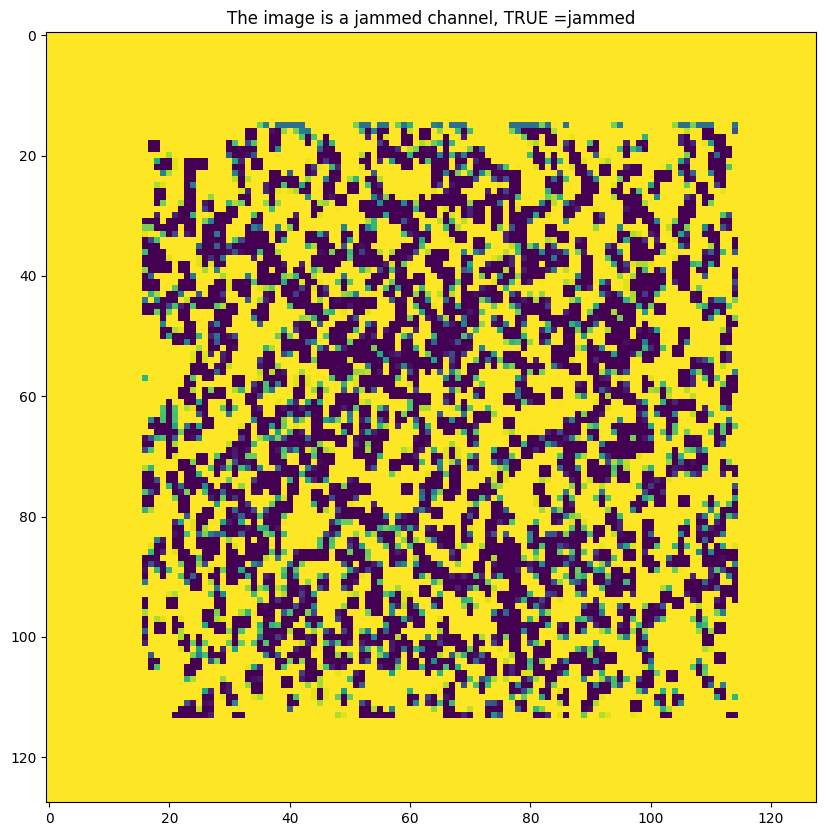

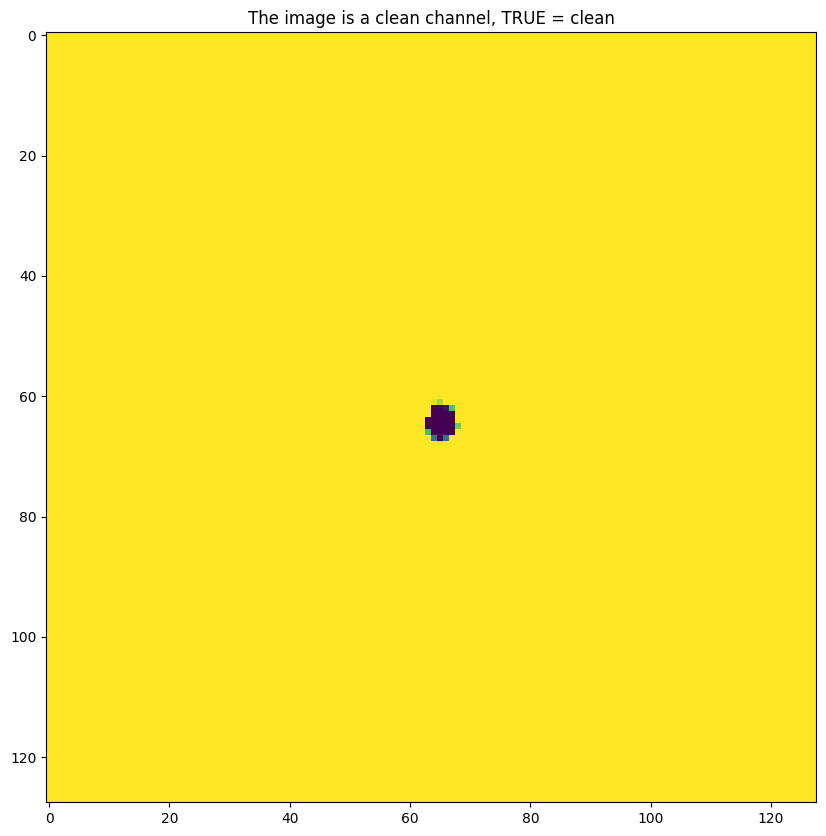

In [43]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [44]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [46]:
values_th=np.arange(normal_values[0],jammed_values[0],0.001)
print(len(values_th))

65


In [47]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0776


  0%|          | 2/800 [00:00<00:51, 15.56it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0192


  0%|          | 4/800 [00:00<00:51, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0769


  1%|          | 6/800 [00:00<00:48, 16.44it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0175


  1%|          | 8/800 [00:00<00:46, 17.02it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0774


  1%|▏         | 10/800 [00:00<00:48, 16.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0770


  2%|▏         | 12/800 [00:00<00:51, 15.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0766


  2%|▏         | 14/800 [00:00<00:49, 15.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0769


  2%|▏         | 16/800 [00:01<00:51, 15.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0770


  2%|▏         | 18/800 [00:01<00:51, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


  2%|▎         | 20/800 [00:01<00:51, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0214


  3%|▎         | 22/800 [00:01<00:49, 15.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0180


  3%|▎         | 24/800 [00:01<00:47, 16.43it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0780


  3%|▎         | 26/800 [00:01<00:45, 16.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0072


  4%|▎         | 28/800 [00:01<00:44, 17.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0773


  4%|▍         | 30/800 [00:01<00:46, 16.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0767


  4%|▍         | 32/800 [00:01<00:47, 16.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


  4%|▍         | 34/800 [00:02<00:46, 16.57it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


  4%|▍         | 36/800 [00:02<00:47, 16.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


  5%|▍         | 38/800 [00:02<00:47, 15.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


  5%|▌         | 40/800 [00:02<00:46, 16.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0196


  5%|▌         | 42/800 [00:02<00:45, 16.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


  6%|▌         | 44/800 [00:02<00:46, 16.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0761


  6%|▌         | 46/800 [00:02<00:46, 16.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0784


  6%|▌         | 48/800 [00:02<00:46, 16.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0206


  6%|▋         | 50/800 [00:03<00:46, 16.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0780


  6%|▋         | 52/800 [00:03<00:45, 16.41it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0072


  7%|▋         | 54/800 [00:03<00:44, 16.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0781


  7%|▋         | 56/800 [00:03<00:44, 16.75it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0783


  7%|▋         | 58/800 [00:03<00:44, 16.73it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0783


  8%|▊         | 60/800 [00:03<00:45, 16.39it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0077


  8%|▊         | 62/800 [00:03<00:43, 16.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0081


  8%|▊         | 64/800 [00:04<01:24,  8.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0780


  8%|▊         | 66/800 [00:04<01:16,  9.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0195


  8%|▊         | 68/800 [00:04<01:09, 10.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


  9%|▉         | 70/800 [00:04<01:04, 11.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


  9%|▉         | 72/800 [00:04<01:01, 11.90it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0781


  9%|▉         | 74/800 [00:05<00:58, 12.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0762


 10%|▉         | 76/800 [00:05<00:58, 12.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 10%|▉         | 78/800 [00:05<00:56, 12.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0776


 10%|█         | 80/800 [00:05<00:55, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0202


 10%|█         | 82/800 [00:05<00:53, 13.49it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0771


 10%|█         | 84/800 [00:05<00:56, 12.74it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0193


 11%|█         | 86/800 [00:06<00:59, 12.04it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0078


 11%|█         | 88/800 [00:06<01:02, 11.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0769


 11%|█▏        | 90/800 [00:06<01:04, 10.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0072


 12%|█▏        | 92/800 [00:06<01:05, 10.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0791


 12%|█▏        | 94/800 [00:06<01:05, 10.78it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0793


 12%|█▏        | 96/800 [00:07<01:10,  9.95it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0078


 12%|█▏        | 98/800 [00:07<01:10,  9.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0176


 12%|█▎        | 100/800 [00:07<01:09, 10.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0197


 13%|█▎        | 102/800 [00:07<01:08, 10.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0192


 13%|█▎        | 104/800 [00:07<01:07, 10.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0166


 13%|█▎        | 106/800 [00:07<01:04, 10.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 14%|█▎        | 108/800 [00:08<00:59, 11.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0780


 14%|█▍        | 110/800 [00:08<00:56, 12.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0791


 14%|█▍        | 112/800 [00:08<00:54, 12.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 14%|█▍        | 114/800 [00:08<00:53, 12.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0394


 14%|█▍        | 116/800 [00:08<00:52, 12.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 15%|█▍        | 118/800 [00:08<00:51, 13.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0078


 15%|█▌        | 120/800 [00:08<00:49, 13.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 15%|█▌        | 122/800 [00:09<00:49, 13.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0778


 16%|█▌        | 124/800 [00:09<00:47, 14.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0792


 16%|█▌        | 126/800 [00:09<00:48, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0771


 16%|█▌        | 128/800 [00:09<00:46, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 16%|█▋        | 130/800 [00:09<00:45, 14.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0220


 16%|█▋        | 132/800 [00:09<00:44, 14.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0078


 17%|█▋        | 134/800 [00:09<00:44, 14.89it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0771


 17%|█▋        | 136/800 [00:10<00:43, 15.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 17%|█▋        | 138/800 [00:10<00:42, 15.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


 18%|█▊        | 140/800 [00:10<00:43, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0793


 18%|█▊        | 142/800 [00:10<00:45, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0781


 18%|█▊        | 144/800 [00:10<00:43, 14.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0193


 18%|█▊        | 146/800 [00:10<00:43, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 18%|█▊        | 148/800 [00:10<00:45, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0776


 19%|█▉        | 150/800 [00:10<00:44, 14.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0789


 19%|█▉        | 152/800 [00:11<00:43, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0782


 19%|█▉        | 154/800 [00:11<00:42, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0077


 20%|█▉        | 156/800 [00:11<00:41, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0080


 20%|█▉        | 158/800 [00:11<00:43, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 20%|██        | 160/800 [00:11<00:41, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 20%|██        | 162/800 [00:11<00:40, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0387


 20%|██        | 164/800 [00:11<00:39, 16.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0806


 21%|██        | 166/800 [00:12<00:41, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0177


 21%|██        | 168/800 [00:12<00:40, 15.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 21%|██▏       | 170/800 [00:12<00:39, 16.04it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0072


 22%|██▏       | 172/800 [00:12<00:40, 15.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0201


 22%|██▏       | 174/800 [00:12<00:40, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 22%|██▏       | 176/800 [00:12<00:40, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


 22%|██▏       | 178/800 [00:12<00:39, 15.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0079


 22%|██▎       | 180/800 [00:12<00:38, 16.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0774


 23%|██▎       | 182/800 [00:13<00:40, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 23%|██▎       | 184/800 [00:13<00:39, 15.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 23%|██▎       | 186/800 [00:13<00:40, 15.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0171


 24%|██▎       | 188/800 [00:13<00:40, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0763


 24%|██▍       | 190/800 [00:13<00:40, 15.16it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0782


 24%|██▍       | 192/800 [00:13<00:40, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0773


 24%|██▍       | 194/800 [00:13<00:39, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 24%|██▍       | 196/800 [00:13<00:39, 15.13it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0200


 25%|██▍       | 198/800 [00:14<00:38, 15.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0783


 25%|██▌       | 200/800 [00:14<00:38, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0779


 25%|██▌       | 202/800 [00:14<00:37, 15.82it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 26%|██▌       | 204/800 [00:14<00:38, 15.43it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 26%|██▌       | 206/800 [00:14<00:37, 15.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0789


 26%|██▌       | 208/800 [00:14<00:38, 15.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0788


 26%|██▋       | 210/800 [00:14<00:39, 15.10it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0773


 26%|██▋       | 212/800 [00:14<00:38, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0079


 27%|██▋       | 214/800 [00:15<00:38, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


 27%|██▋       | 216/800 [00:15<00:37, 15.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0781


 27%|██▋       | 218/800 [00:15<00:37, 15.32it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0202


 28%|██▊       | 220/800 [00:15<00:38, 15.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


 28%|██▊       | 222/800 [00:15<00:37, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 28%|██▊       | 224/800 [00:15<00:37, 15.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 28%|██▊       | 226/800 [00:15<00:37, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 28%|██▊       | 228/800 [00:16<00:38, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 29%|██▉       | 230/800 [00:16<00:36, 15.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0759


 29%|██▉       | 232/800 [00:16<00:36, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0770


 29%|██▉       | 234/800 [00:16<00:36, 15.67it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 30%|██▉       | 236/800 [00:16<00:35, 15.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


 30%|██▉       | 238/800 [00:16<00:34, 16.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0769


 30%|███       | 240/800 [00:16<00:35, 15.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0782


 30%|███       | 242/800 [00:16<00:36, 15.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0194


 30%|███       | 244/800 [00:17<00:36, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0194


 31%|███       | 246/800 [00:17<00:36, 15.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0080


 31%|███       | 248/800 [00:17<00:35, 15.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 31%|███▏      | 250/800 [00:17<00:36, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 32%|███▏      | 252/800 [00:17<00:36, 15.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0773


 32%|███▏      | 254/800 [00:17<00:36, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0201


 32%|███▏      | 256/800 [00:17<00:36, 14.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0762


 32%|███▏      | 258/800 [00:18<00:38, 13.96it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0191


 32%|███▎      | 260/800 [00:18<00:41, 13.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0196


 33%|███▎      | 262/800 [00:18<00:41, 12.85it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0207


 33%|███▎      | 264/800 [00:18<00:42, 12.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0787


 33%|███▎      | 266/800 [00:18<00:41, 12.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0769


 34%|███▎      | 268/800 [00:18<00:41, 12.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0781


 34%|███▍      | 270/800 [00:19<00:42, 12.43it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0792


 34%|███▍      | 272/800 [00:19<00:44, 11.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0199


 34%|███▍      | 274/800 [00:19<00:44, 11.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0379


 34%|███▍      | 276/800 [00:19<00:44, 11.67it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0766


 35%|███▍      | 278/800 [00:19<00:45, 11.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0789


 35%|███▌      | 280/800 [00:19<00:45, 11.33it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0783


 35%|███▌      | 282/800 [00:20<00:45, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0784


 36%|███▌      | 284/800 [00:20<00:45, 11.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


 36%|███▌      | 286/800 [00:20<00:41, 12.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


 36%|███▌      | 288/800 [00:20<00:37, 13.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 36%|███▋      | 290/800 [00:20<00:36, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0198


 36%|███▋      | 292/800 [00:20<00:35, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0760


 37%|███▋      | 294/800 [00:20<00:34, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0764


 37%|███▋      | 296/800 [00:21<00:34, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0786


 37%|███▋      | 298/800 [00:21<00:33, 15.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0778


 38%|███▊      | 300/800 [00:21<00:31, 15.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0778


 38%|███▊      | 302/800 [00:21<00:32, 15.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 38%|███▊      | 304/800 [00:21<00:32, 15.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0773


 38%|███▊      | 306/800 [00:21<00:32, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0776


 38%|███▊      | 308/800 [00:21<00:32, 15.36it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0777


 39%|███▉      | 310/800 [00:21<00:31, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0793


 39%|███▉      | 312/800 [00:22<00:32, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 39%|███▉      | 314/800 [00:22<00:31, 15.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0755


 40%|███▉      | 316/800 [00:22<00:30, 15.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 40%|███▉      | 318/800 [00:22<00:30, 15.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 40%|████      | 320/800 [00:22<00:31, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0795


 40%|████      | 322/800 [00:22<00:31, 15.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0768


 40%|████      | 324/800 [00:22<00:30, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0773


 41%|████      | 326/800 [00:22<00:30, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 41%|████      | 328/800 [00:23<00:30, 15.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 41%|████▏     | 330/800 [00:23<00:30, 15.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0783


 42%|████▏     | 332/800 [00:23<00:29, 15.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 42%|████▏     | 334/800 [00:23<00:29, 15.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0770


 42%|████▏     | 336/800 [00:23<00:29, 15.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


 42%|████▏     | 338/800 [00:23<00:29, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 42%|████▎     | 340/800 [00:23<00:29, 15.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0796


 43%|████▎     | 342/800 [00:23<00:29, 15.34it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0192


 43%|████▎     | 344/800 [00:24<00:29, 15.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0189


 43%|████▎     | 346/800 [00:24<00:29, 15.27it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0173


 44%|████▎     | 348/800 [00:24<00:28, 15.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0785


 44%|████▍     | 350/800 [00:24<00:28, 15.86it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0206


 44%|████▍     | 352/800 [00:24<00:28, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0766


 44%|████▍     | 354/800 [00:24<00:29, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 44%|████▍     | 356/800 [00:24<00:29, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0766


 45%|████▍     | 358/800 [00:25<00:29, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


 45%|████▌     | 360/800 [00:25<00:28, 15.21it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0795


 45%|████▌     | 362/800 [00:25<00:29, 14.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0780


 46%|████▌     | 364/800 [00:25<00:29, 14.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0793


 46%|████▌     | 366/800 [00:25<00:29, 14.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0204


 46%|████▌     | 368/800 [00:25<00:28, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0215


 46%|████▋     | 370/800 [00:25<00:28, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0755


 46%|████▋     | 372/800 [00:25<00:28, 14.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 47%|████▋     | 374/800 [00:26<00:28, 14.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0773


 47%|████▋     | 376/800 [00:26<00:28, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0787


 47%|████▋     | 378/800 [00:26<00:27, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 48%|████▊     | 380/800 [00:26<00:26, 15.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 48%|████▊     | 382/800 [00:26<00:26, 15.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


 48%|████▊     | 384/800 [00:26<00:26, 15.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0782


 48%|████▊     | 386/800 [00:26<00:27, 15.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0777


 48%|████▊     | 388/800 [00:27<00:27, 14.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0765


 49%|████▉     | 390/800 [00:27<00:26, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0770


 49%|████▉     | 392/800 [00:27<00:26, 15.40it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0784


 49%|████▉     | 394/800 [00:27<00:25, 15.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 50%|████▉     | 396/800 [00:27<00:25, 15.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0765


 50%|████▉     | 398/800 [00:27<00:26, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0774


 50%|█████     | 400/800 [00:27<00:26, 15.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0166


 50%|█████     | 402/800 [00:27<00:26, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 50%|█████     | 404/800 [00:28<00:25, 15.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 51%|█████     | 406/800 [00:28<00:26, 15.11it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0793


 51%|█████     | 408/800 [00:28<00:24, 15.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0192


 51%|█████▏    | 410/800 [00:28<00:24, 15.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0776


 52%|█████▏    | 412/800 [00:28<00:24, 15.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0216


 52%|█████▏    | 414/800 [00:28<00:25, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 52%|█████▏    | 416/800 [00:28<00:25, 15.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0780


 52%|█████▏    | 418/800 [00:28<00:25, 15.19it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0773


 52%|█████▎    | 420/800 [00:29<00:24, 15.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0785


 53%|█████▎    | 422/800 [00:29<00:24, 15.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0780


 53%|█████▎    | 424/800 [00:29<00:24, 15.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0770


 53%|█████▎    | 426/800 [00:29<00:24, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0199


 54%|█████▎    | 428/800 [00:29<00:24, 15.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0201


 54%|█████▍    | 430/800 [00:29<00:24, 15.31it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


 54%|█████▍    | 432/800 [00:29<00:24, 14.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0212


 54%|█████▍    | 434/800 [00:30<00:25, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 55%|█████▍    | 436/800 [00:30<00:24, 14.57it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0779


 55%|█████▍    | 438/800 [00:30<00:25, 14.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 55%|█████▌    | 440/800 [00:30<00:26, 13.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0786


 55%|█████▌    | 442/800 [00:30<00:28, 12.55it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0777


 56%|█████▌    | 444/800 [00:30<00:29, 12.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 56%|█████▌    | 446/800 [00:30<00:29, 12.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0072


 56%|█████▌    | 448/800 [00:31<00:29, 11.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0200


 56%|█████▋    | 450/800 [00:31<00:30, 11.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0170


 56%|█████▋    | 452/800 [00:31<00:30, 11.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0176


 57%|█████▋    | 454/800 [00:31<00:29, 11.64it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0775


 57%|█████▋    | 456/800 [00:31<00:29, 11.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0760


 57%|█████▋    | 458/800 [00:32<00:29, 11.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0771


 57%|█████▊    | 460/800 [00:32<00:29, 11.34it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0770


 58%|█████▊    | 462/800 [00:32<00:29, 11.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0781


 58%|█████▊    | 464/800 [00:32<00:29, 11.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0784


 58%|█████▊    | 466/800 [00:32<00:28, 11.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


 58%|█████▊    | 468/800 [00:32<00:27, 12.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 59%|█████▉    | 470/800 [00:33<00:25, 12.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0784


 59%|█████▉    | 472/800 [00:33<00:24, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0790


 59%|█████▉    | 474/800 [00:33<00:23, 13.89it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0167


 60%|█████▉    | 476/800 [00:33<00:22, 14.47it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 60%|█████▉    | 478/800 [00:33<00:21, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0775


 60%|██████    | 480/800 [00:33<00:21, 15.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0214


 60%|██████    | 482/800 [00:33<00:21, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 60%|██████    | 484/800 [00:33<00:21, 14.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0204


 61%|██████    | 486/800 [00:34<00:21, 14.42it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0079


 61%|██████    | 488/800 [00:34<00:21, 14.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0795


 61%|██████▏   | 490/800 [00:34<00:20, 14.83it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 62%|██████▏   | 492/800 [00:34<00:19, 15.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 62%|██████▏   | 494/800 [00:34<00:19, 15.31it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


 62%|██████▏   | 496/800 [00:34<00:20, 14.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 62%|██████▏   | 498/800 [00:34<00:19, 15.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0775


 62%|██████▎   | 500/800 [00:35<00:19, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0788


 63%|██████▎   | 502/800 [00:35<00:20, 14.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0792


 63%|██████▎   | 504/800 [00:35<00:19, 14.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0781


 63%|██████▎   | 506/800 [00:35<00:19, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0173


 64%|██████▎   | 508/800 [00:35<00:18, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0075


 64%|██████▍   | 510/800 [00:35<00:19, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0784


 64%|██████▍   | 512/800 [00:35<00:19, 14.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0783


 64%|██████▍   | 514/800 [00:35<00:19, 14.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0072


 64%|██████▍   | 516/800 [00:36<00:19, 14.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 65%|██████▍   | 518/800 [00:36<00:18, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0754


 65%|██████▌   | 520/800 [00:36<00:18, 14.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0190


 65%|██████▌   | 522/800 [00:36<00:18, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 66%|██████▌   | 524/800 [00:36<00:18, 15.01it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0210


 66%|██████▌   | 526/800 [00:36<00:18, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 66%|██████▌   | 528/800 [00:36<00:18, 14.87it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0201


 66%|██████▋   | 530/800 [00:37<00:18, 14.72it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0784


 66%|██████▋   | 532/800 [00:37<00:17, 15.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0771


 67%|██████▋   | 534/800 [00:37<00:17, 15.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 67%|██████▋   | 536/800 [00:37<00:17, 15.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


 67%|██████▋   | 538/800 [00:37<00:16, 15.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0785


 68%|██████▊   | 540/800 [00:37<00:16, 15.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0775


 68%|██████▊   | 542/800 [00:37<00:16, 15.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0200


 68%|██████▊   | 544/800 [00:37<00:17, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 68%|██████▊   | 546/800 [00:38<00:17, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0205


 68%|██████▊   | 548/800 [00:38<00:17, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0196


 69%|██████▉   | 550/800 [00:38<00:16, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 69%|██████▉   | 552/800 [00:38<00:16, 15.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0790


 69%|██████▉   | 554/800 [00:38<00:16, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0194


 70%|██████▉   | 556/800 [00:38<00:16, 14.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0073


 70%|██████▉   | 558/800 [00:38<00:16, 15.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0771


 70%|███████   | 560/800 [00:39<00:16, 14.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 70%|███████   | 562/800 [00:39<00:16, 14.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0203


 70%|███████   | 564/800 [00:39<00:16, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0778


 71%|███████   | 566/800 [00:39<00:15, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 71%|███████   | 568/800 [00:39<00:15, 15.24it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0209


 71%|███████▏  | 570/800 [00:39<00:15, 15.27it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0077


 72%|███████▏  | 572/800 [00:39<00:15, 15.01it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0794


 72%|███████▏  | 574/800 [00:39<00:15, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0200


 72%|███████▏  | 576/800 [00:40<00:15, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0783


 72%|███████▏  | 578/800 [00:40<00:15, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 72%|███████▎  | 580/800 [00:40<00:14, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 73%|███████▎  | 582/800 [00:40<00:14, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 73%|███████▎  | 584/800 [00:40<00:14, 15.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 73%|███████▎  | 586/800 [00:40<00:14, 15.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0164


 74%|███████▎  | 588/800 [00:40<00:14, 14.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0800


 74%|███████▍  | 590/800 [00:41<00:15, 13.97it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0166


 74%|███████▍  | 592/800 [00:41<00:14, 14.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0772


 74%|███████▍  | 594/800 [00:41<00:14, 14.50it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0791


 74%|███████▍  | 596/800 [00:41<00:13, 14.95it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0079


 75%|███████▍  | 598/800 [00:41<00:13, 14.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0376


 75%|███████▌  | 600/800 [00:41<00:13, 14.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 75%|███████▌  | 602/800 [00:41<00:13, 14.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0198


 76%|███████▌  | 604/800 [00:42<00:13, 14.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 76%|███████▌  | 606/800 [00:42<00:13, 14.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0764


 76%|███████▌  | 608/800 [00:42<00:13, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0383


 76%|███████▋  | 610/800 [00:42<00:12, 14.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


 76%|███████▋  | 612/800 [00:42<00:12, 14.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0795


 77%|███████▋  | 614/800 [00:42<00:12, 15.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0788


 77%|███████▋  | 616/800 [00:42<00:13, 13.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0072


 77%|███████▋  | 618/800 [00:43<00:14, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0794


 78%|███████▊  | 620/800 [00:43<00:14, 12.74it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0775


 78%|███████▊  | 622/800 [00:43<00:13, 12.91it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0198


 78%|███████▊  | 624/800 [00:43<00:13, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 78%|███████▊  | 626/800 [00:43<00:13, 13.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0767


 78%|███████▊  | 628/800 [00:43<00:12, 13.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0775


 79%|███████▉  | 630/800 [00:43<00:12, 13.10it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0196


 79%|███████▉  | 632/800 [00:44<00:13, 12.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0786


 79%|███████▉  | 634/800 [00:44<00:13, 12.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 80%|███████▉  | 636/800 [00:44<00:13, 12.30it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0198


 80%|███████▉  | 638/800 [00:44<00:13, 12.37it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0788


 80%|████████  | 640/800 [00:44<00:13, 12.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 80%|████████  | 642/800 [00:44<00:13, 11.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0770


 80%|████████  | 644/800 [00:45<00:13, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0779


 81%|████████  | 646/800 [00:45<00:13, 11.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


 81%|████████  | 648/800 [00:45<00:13, 11.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0778


 81%|████████▏ | 650/800 [00:45<00:12, 11.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0802


 82%|████████▏ | 652/800 [00:45<00:11, 12.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0200


 82%|████████▏ | 654/800 [00:45<00:11, 13.09it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0183


 82%|████████▏ | 656/800 [00:46<00:10, 13.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0769


 82%|████████▏ | 658/800 [00:46<00:10, 13.66it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0789


 82%|████████▎ | 660/800 [00:46<00:09, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 83%|████████▎ | 662/800 [00:46<00:09, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


 83%|████████▎ | 664/800 [00:46<00:09, 14.63it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0783


 83%|████████▎ | 666/800 [00:46<00:09, 14.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0209


 84%|████████▎ | 668/800 [00:46<00:09, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 84%|████████▍ | 670/800 [00:47<00:09, 14.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0167


 84%|████████▍ | 672/800 [00:47<00:08, 14.39it/s]

1/1 [==============================] - 0s 20ms/step - loss: 0.0774


 84%|████████▍ | 674/800 [00:47<00:08, 14.88it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 84%|████████▍ | 676/800 [00:47<00:08, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0174


 85%|████████▍ | 678/800 [00:47<00:08, 14.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0211


 85%|████████▌ | 680/800 [00:47<00:08, 14.76it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0765


 85%|████████▌ | 682/800 [00:47<00:07, 15.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0208


 86%|████████▌ | 684/800 [00:47<00:07, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 86%|████████▌ | 686/800 [00:48<00:07, 14.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 86%|████████▌ | 688/800 [00:48<00:07, 14.77it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0190


 86%|████████▋ | 690/800 [00:48<00:07, 15.27it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 86%|████████▋ | 692/800 [00:48<00:07, 15.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0216


 87%|████████▋ | 694/800 [00:48<00:06, 15.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0202


 87%|████████▋ | 696/800 [00:48<00:06, 15.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0170


 87%|████████▋ | 698/800 [00:48<00:06, 15.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 88%|████████▊ | 700/800 [00:49<00:06, 15.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0772


 88%|████████▊ | 702/800 [00:49<00:06, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0780


 88%|████████▊ | 704/800 [00:49<00:06, 14.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0769


 88%|████████▊ | 706/800 [00:49<00:06, 14.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0767


 88%|████████▊ | 708/800 [00:49<00:06, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 89%|████████▉ | 710/800 [00:49<00:06, 14.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 89%|████████▉ | 712/800 [00:49<00:05, 14.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 89%|████████▉ | 714/800 [00:49<00:05, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 90%|████████▉ | 716/800 [00:50<00:05, 14.84it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 90%|████████▉ | 718/800 [00:50<00:05, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0780


 90%|█████████ | 720/800 [00:50<00:05, 14.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0772


 90%|█████████ | 722/800 [00:50<00:05, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0730


 90%|█████████ | 724/800 [00:50<00:05, 14.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0195


 91%|█████████ | 726/800 [00:50<00:05, 14.59it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0079


 91%|█████████ | 728/800 [00:50<00:05, 13.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0166


 91%|█████████▏| 730/800 [00:51<00:04, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0776


 92%|█████████▏| 732/800 [00:51<00:04, 14.44it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0783


 92%|█████████▏| 734/800 [00:51<00:04, 14.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0079


 92%|█████████▏| 736/800 [00:51<00:04, 14.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0773


 92%|█████████▏| 738/800 [00:51<00:04, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0195


 92%|█████████▎| 740/800 [00:51<00:03, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0758


 93%|█████████▎| 742/800 [00:51<00:03, 14.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0780


 93%|█████████▎| 744/800 [00:52<00:03, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0782


 93%|█████████▎| 746/800 [00:52<00:03, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0206


 94%|█████████▎| 748/800 [00:52<00:03, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


 94%|█████████▍| 750/800 [00:52<00:03, 14.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0077


 94%|█████████▍| 752/800 [00:52<00:03, 14.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0170


 94%|█████████▍| 754/800 [00:52<00:03, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 94%|█████████▍| 756/800 [00:52<00:02, 14.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0785


 95%|█████████▍| 758/800 [00:52<00:02, 14.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0212


 95%|█████████▌| 760/800 [00:53<00:02, 14.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 95%|█████████▌| 762/800 [00:53<00:02, 14.38it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0779


 96%|█████████▌| 764/800 [00:53<00:02, 14.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0761


 96%|█████████▌| 766/800 [00:53<00:02, 14.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0774


 96%|█████████▌| 768/800 [00:53<00:02, 14.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 96%|█████████▋| 770/800 [00:53<00:02, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0174


 96%|█████████▋| 772/800 [00:53<00:01, 14.62it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 97%|█████████▋| 774/800 [00:54<00:01, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0194


 97%|█████████▋| 776/800 [00:54<00:01, 14.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 97%|█████████▋| 778/800 [00:54<00:01, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0770


 98%|█████████▊| 780/800 [00:54<00:01, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0778


 98%|█████████▊| 782/800 [00:54<00:01, 14.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 98%|█████████▊| 784/800 [00:54<00:01, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0194


 98%|█████████▊| 786/800 [00:54<00:00, 14.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0771


 98%|█████████▊| 788/800 [00:55<00:00, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 99%|█████████▉| 790/800 [00:55<00:00, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0077


 99%|█████████▉| 792/800 [00:55<00:00, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0789


 99%|█████████▉| 794/800 [00:55<00:00, 14.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0078


100%|█████████▉| 796/800 [00:55<00:00, 14.20it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0788


100%|█████████▉| 798/800 [00:55<00:00, 12.83it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0795


100%|██████████| 800/800 [00:56<00:00, 14.28it/s]

800


In [48]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [49]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [50]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.00125, 0.00875, 0.06125, 0.2275]
[0.26625, 0.26625, 0.265, 0.2525, 0.2175, 0.17375, 0.115, 0.05375, 0.01875, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.01375, 0.01375, 0.0125, 0.005, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


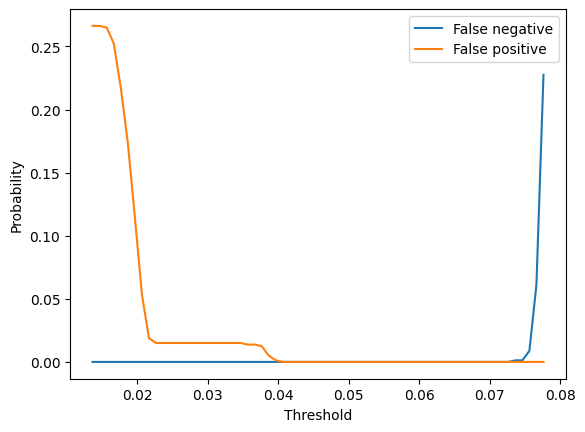

In [51]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [52]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0776


  0%|          | 2/800 [00:00<00:53, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0192


  0%|          | 4/800 [00:00<00:50, 15.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0769


  1%|          | 6/800 [00:00<00:50, 15.69it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0175


  1%|          | 8/800 [00:00<01:00, 13.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0774


  1%|▏         | 10/800 [00:00<01:04, 12.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0770


  2%|▏         | 12/800 [00:00<01:05, 12.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0766


  2%|▏         | 14/800 [00:01<01:03, 12.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0769


  2%|▏         | 16/800 [00:01<01:02, 12.53it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0770


  2%|▏         | 18/800 [00:01<01:04, 12.14it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0771


  2%|▎         | 20/800 [00:01<01:03, 12.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0214


  3%|▎         | 22/800 [00:01<01:03, 12.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


  3%|▎         | 24/800 [00:01<01:05, 11.77it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0780


  3%|▎         | 26/800 [00:02<01:06, 11.57it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0072


  4%|▎         | 28/800 [00:02<01:06, 11.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0773


  4%|▍         | 30/800 [00:02<01:06, 11.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


  4%|▍         | 32/800 [00:02<01:03, 12.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


  4%|▍         | 34/800 [00:02<00:59, 12.85it/s]

1/1 [==============================] - 0s 90ms/step - loss: 0.0072


  4%|▍         | 36/800 [00:03<01:18,  9.70it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0777


  5%|▍         | 38/800 [00:03<01:18,  9.75it/s]

1/1 [==============================] - 0s 83ms/step - loss: 0.0072


  5%|▌         | 40/800 [00:03<01:33,  8.13it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0787


  5%|▌         | 41/800 [00:03<01:35,  7.92it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0196


  5%|▌         | 42/800 [00:03<01:43,  7.31it/s]

1/1 [==============================] - 0s 75ms/step - loss: 0.0790


  5%|▌         | 43/800 [00:04<01:45,  7.20it/s]

1/1 [==============================] - 0s 96ms/step - loss: 0.0072


  6%|▌         | 44/800 [00:04<02:04,  6.06it/s]

1/1 [==============================] - 0s 67ms/step - loss: 0.0774


  6%|▌         | 45/800 [00:04<02:06,  5.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0761


  6%|▌         | 46/800 [00:04<02:03,  6.09it/s]

1/1 [==============================] - 0s 78ms/step - loss: 0.0182


  6%|▌         | 47/800 [00:04<02:35,  4.84it/s]

1/1 [==============================] - 0s 102ms/step - loss: 0.0784


  6%|▌         | 48/800 [00:05<02:32,  4.94it/s]

1/1 [==============================] - 0s 107ms/step - loss: 0.0780


  6%|▌         | 49/800 [00:05<02:37,  4.76it/s]

1/1 [==============================] - 0s 71ms/step - loss: 0.0206


  6%|▋         | 50/800 [00:05<02:20,  5.34it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0183


  6%|▋         | 51/800 [00:05<02:10,  5.75it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0780


  6%|▋         | 52/800 [00:05<02:00,  6.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0769


  7%|▋         | 53/800 [00:05<01:51,  6.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0787


  7%|▋         | 55/800 [00:06<01:36,  7.74it/s]

1/1 [==============================] - 0s 132ms/step - loss: 0.0781


  7%|▋         | 56/800 [00:06<01:47,  6.90it/s]

1/1 [==============================] - 0s 82ms/step - loss: 0.0192


  7%|▋         | 57/800 [00:06<02:04,  5.95it/s]

1/1 [==============================] - 0s 126ms/step - loss: 0.0783


  7%|▋         | 58/800 [00:06<02:22,  5.22it/s]

1/1 [==============================] - 0s 102ms/step - loss: 0.0376


  7%|▋         | 59/800 [00:06<02:21,  5.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0783


  8%|▊         | 60/800 [00:07<02:15,  5.47it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0193


  8%|▊         | 61/800 [00:07<02:14,  5.48it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0077


  8%|▊         | 62/800 [00:07<02:06,  5.82it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0774


  8%|▊         | 63/800 [00:07<01:52,  6.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0081


  8%|▊         | 64/800 [00:07<01:41,  7.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


  8%|▊         | 66/800 [00:07<01:17,  9.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0195


  8%|▊         | 68/800 [00:07<01:05, 11.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0172


  9%|▉         | 70/800 [00:08<00:59, 12.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


  9%|▉         | 72/800 [00:08<00:54, 13.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0781


  9%|▉         | 74/800 [00:08<00:54, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0762


 10%|▉         | 76/800 [00:08<00:50, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 10%|▉         | 78/800 [00:08<00:50, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0776


 10%|█         | 80/800 [00:08<00:49, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0202


 10%|█         | 82/800 [00:08<00:49, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0771


 10%|█         | 84/800 [00:09<00:47, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0193


 11%|█         | 86/800 [00:09<00:47, 15.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0078


 11%|█         | 88/800 [00:09<00:47, 15.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0769


 11%|█▏        | 90/800 [00:09<00:48, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 12%|█▏        | 92/800 [00:09<00:46, 15.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0791


 12%|█▏        | 94/800 [00:09<00:46, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0793


 12%|█▏        | 96/800 [00:09<00:46, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0078


 12%|█▏        | 98/800 [00:09<00:46, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0176


 12%|█▎        | 100/800 [00:10<00:45, 15.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0197


 13%|█▎        | 102/800 [00:10<00:44, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0192


 13%|█▎        | 104/800 [00:10<00:44, 15.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0166


 13%|█▎        | 106/800 [00:10<00:43, 15.89it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 14%|█▎        | 108/800 [00:10<00:44, 15.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0780


 14%|█▍        | 110/800 [00:10<00:44, 15.36it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0791


 14%|█▍        | 112/800 [00:10<00:45, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 14%|█▍        | 114/800 [00:10<00:44, 15.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0394


 14%|█▍        | 116/800 [00:11<00:43, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0175


 15%|█▍        | 118/800 [00:11<00:42, 16.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0078


 15%|█▌        | 120/800 [00:11<00:42, 16.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 15%|█▌        | 122/800 [00:11<00:41, 16.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0778


 16%|█▌        | 124/800 [00:11<00:41, 16.12it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0792


 16%|█▌        | 126/800 [00:11<00:40, 16.52it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0771


 16%|█▌        | 128/800 [00:11<00:40, 16.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


 16%|█▋        | 130/800 [00:11<00:42, 15.78it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0220


 16%|█▋        | 132/800 [00:12<01:18,  8.56it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0078


 17%|█▋        | 134/800 [00:12<01:10,  9.43it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0771


 17%|█▋        | 136/800 [00:12<01:07,  9.90it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0072


 17%|█▋        | 138/800 [00:12<01:06,  9.98it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0773


 18%|█▊        | 140/800 [00:13<01:06,  9.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0793


 18%|█▊        | 142/800 [00:13<01:04, 10.16it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0781


 18%|█▊        | 144/800 [00:13<01:03, 10.31it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0193


 18%|█▊        | 146/800 [00:13<01:02, 10.41it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0187


 18%|█▊        | 148/800 [00:13<01:02, 10.35it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0776


 19%|█▉        | 150/800 [00:14<01:01, 10.56it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0789


 19%|█▉        | 152/800 [00:14<01:01, 10.46it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0782


 19%|█▉        | 154/800 [00:14<01:01, 10.59it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0077


 20%|█▉        | 156/800 [00:14<01:02, 10.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0080


 20%|█▉        | 158/800 [00:14<00:59, 10.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 20%|██        | 160/800 [00:15<00:54, 11.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 20%|██        | 162/800 [00:15<00:50, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0387


 20%|██        | 164/800 [00:15<00:50, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0806


 21%|██        | 166/800 [00:15<00:49, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


 21%|██        | 168/800 [00:15<00:47, 13.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 21%|██▏       | 170/800 [00:15<00:46, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 22%|██▏       | 172/800 [00:15<00:46, 13.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0201


 22%|██▏       | 174/800 [00:16<00:45, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 22%|██▏       | 176/800 [00:16<00:46, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0774


 22%|██▏       | 178/800 [00:16<00:44, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0079


 22%|██▎       | 180/800 [00:16<00:44, 13.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0774


 23%|██▎       | 182/800 [00:16<00:44, 14.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0775


 23%|██▎       | 184/800 [00:16<00:43, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


 23%|██▎       | 186/800 [00:16<00:42, 14.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0171


 24%|██▎       | 188/800 [00:16<00:43, 14.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0763


 24%|██▍       | 190/800 [00:17<00:44, 13.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0782


 24%|██▍       | 192/800 [00:17<00:44, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0773


 24%|██▍       | 194/800 [00:17<00:43, 14.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0762


 24%|██▍       | 196/800 [00:17<00:42, 14.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0200


 25%|██▍       | 198/800 [00:17<00:43, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0783


 25%|██▌       | 200/800 [00:17<00:42, 14.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0779


 25%|██▌       | 202/800 [00:17<00:41, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 26%|██▌       | 204/800 [00:18<00:41, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0077


 26%|██▌       | 206/800 [00:18<00:42, 14.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0789


 26%|██▌       | 208/800 [00:18<00:40, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0788


 26%|██▋       | 210/800 [00:18<00:39, 14.79it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0773


 26%|██▋       | 212/800 [00:18<00:39, 15.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0079


 27%|██▋       | 214/800 [00:18<00:38, 15.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 27%|██▋       | 216/800 [00:18<00:38, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 27%|██▋       | 218/800 [00:19<00:39, 14.66it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0202


 28%|██▊       | 220/800 [00:19<00:37, 15.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 28%|██▊       | 222/800 [00:19<00:39, 14.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 28%|██▊       | 224/800 [00:19<00:38, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 28%|██▊       | 226/800 [00:19<00:37, 15.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 28%|██▊       | 228/800 [00:19<00:37, 15.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 29%|██▉       | 230/800 [00:19<00:36, 15.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0759


 29%|██▉       | 232/800 [00:19<00:37, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 29%|██▉       | 234/800 [00:20<00:38, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 30%|██▉       | 236/800 [00:20<00:38, 14.80it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0774


 30%|██▉       | 238/800 [00:20<00:36, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0769


 30%|███       | 240/800 [00:20<00:36, 15.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0782


 30%|███       | 242/800 [00:20<00:36, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0194


 30%|███       | 244/800 [00:20<00:35, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0194


 31%|███       | 246/800 [00:20<00:36, 15.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0080


 31%|███       | 248/800 [00:21<00:36, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 31%|███▏      | 250/800 [00:21<00:35, 15.30it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 32%|███▏      | 252/800 [00:21<00:36, 15.18it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0773


 32%|███▏      | 254/800 [00:21<00:36, 15.04it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0201


 32%|███▏      | 256/800 [00:21<00:35, 15.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0762


 32%|███▏      | 258/800 [00:21<00:36, 15.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0191


 32%|███▎      | 260/800 [00:21<00:35, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0196


 33%|███▎      | 262/800 [00:21<00:35, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0207


 33%|███▎      | 264/800 [00:22<00:34, 15.35it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0787


 33%|███▎      | 266/800 [00:22<00:35, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0769


 34%|███▎      | 268/800 [00:22<00:34, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0781


 34%|███▍      | 270/800 [00:22<00:33, 15.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0792


 34%|███▍      | 272/800 [00:22<00:34, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0199


 34%|███▍      | 274/800 [00:22<00:33, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0379


 34%|███▍      | 276/800 [00:22<00:33, 15.50it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0766


 35%|███▍      | 278/800 [00:22<00:33, 15.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0789


 35%|███▌      | 280/800 [00:23<00:34, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0783


 35%|███▌      | 282/800 [00:23<00:33, 15.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0784


 36%|███▌      | 284/800 [00:23<00:35, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


 36%|███▌      | 286/800 [00:23<00:33, 15.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0774


 36%|███▌      | 288/800 [00:23<00:33, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 36%|███▋      | 290/800 [00:23<00:33, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0198


 36%|███▋      | 292/800 [00:23<00:33, 15.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0760


 37%|███▋      | 294/800 [00:24<00:31, 15.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0764


 37%|███▋      | 296/800 [00:24<00:32, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0786


 37%|███▋      | 298/800 [00:24<00:32, 15.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0778


 38%|███▊      | 300/800 [00:24<00:33, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0778


 38%|███▊      | 302/800 [00:24<00:32, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 38%|███▊      | 304/800 [00:24<00:32, 15.40it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0773


 38%|███▊      | 306/800 [00:24<00:35, 13.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0776


 38%|███▊      | 308/800 [00:25<00:39, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0777


 39%|███▉      | 310/800 [00:25<00:41, 11.70it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0793


 39%|███▉      | 312/800 [00:25<00:41, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0777


 39%|███▉      | 314/800 [00:25<00:42, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0755


 40%|███▉      | 316/800 [00:25<00:42, 11.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0072


 40%|███▉      | 318/800 [00:25<00:42, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0775


 40%|████      | 320/800 [00:26<00:42, 11.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0795


 40%|████      | 322/800 [00:26<00:42, 11.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0768


 40%|████      | 324/800 [00:26<00:42, 11.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0773


 41%|████      | 326/800 [00:26<00:42, 11.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0072


 41%|████      | 328/800 [00:26<00:42, 11.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 41%|████▏     | 330/800 [00:27<00:41, 11.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0783


 42%|████▏     | 332/800 [00:27<00:39, 11.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 42%|████▏     | 334/800 [00:27<00:35, 13.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 42%|████▏     | 336/800 [00:27<00:34, 13.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0190


 42%|████▏     | 338/800 [00:27<00:32, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 42%|████▎     | 340/800 [00:27<00:31, 14.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0796


 43%|████▎     | 342/800 [00:27<00:30, 15.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 43%|████▎     | 344/800 [00:27<00:31, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


 43%|████▎     | 346/800 [00:28<00:30, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0173


 44%|████▎     | 348/800 [00:28<00:29, 15.30it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0785


 44%|████▍     | 350/800 [00:28<00:28, 15.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0206


 44%|████▍     | 352/800 [00:28<00:29, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0766


 44%|████▍     | 354/800 [00:28<00:29, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 44%|████▍     | 356/800 [00:28<00:28, 15.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0766


 45%|████▍     | 358/800 [00:28<00:28, 15.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


 45%|████▌     | 360/800 [00:28<00:27, 15.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0795


 45%|████▌     | 362/800 [00:29<00:28, 15.55it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0780


 46%|████▌     | 364/800 [00:29<00:28, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0793


 46%|████▌     | 366/800 [00:29<00:28, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0204


 46%|████▌     | 368/800 [00:29<00:27, 15.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0215


 46%|████▋     | 370/800 [00:29<00:27, 15.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0755


 46%|████▋     | 372/800 [00:29<00:27, 15.66it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 47%|████▋     | 374/800 [00:29<00:27, 15.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0773


 47%|████▋     | 376/800 [00:29<00:26, 15.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0787


 47%|████▋     | 378/800 [00:30<00:27, 15.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 48%|████▊     | 380/800 [00:30<00:27, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 48%|████▊     | 382/800 [00:30<00:27, 15.44it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0195


 48%|████▊     | 384/800 [00:30<00:26, 15.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0782


 48%|████▊     | 386/800 [00:30<00:26, 15.36it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0777


 48%|████▊     | 388/800 [00:30<00:26, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0765


 49%|████▉     | 390/800 [00:30<00:26, 15.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0770


 49%|████▉     | 392/800 [00:31<00:26, 15.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0784


 49%|████▉     | 394/800 [00:31<00:26, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 50%|████▉     | 396/800 [00:31<00:27, 14.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


 50%|████▉     | 398/800 [00:31<00:26, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0774


 50%|█████     | 400/800 [00:31<00:26, 15.21it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0166


 50%|█████     | 402/800 [00:31<00:26, 15.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 50%|█████     | 404/800 [00:31<00:26, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 51%|█████     | 406/800 [00:31<00:25, 15.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0793


 51%|█████     | 408/800 [00:32<00:25, 15.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0192


 51%|█████▏    | 410/800 [00:32<00:25, 15.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0776


 52%|█████▏    | 412/800 [00:32<00:25, 15.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0216


 52%|█████▏    | 414/800 [00:32<00:25, 15.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0078


 52%|█████▏    | 416/800 [00:32<00:25, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0780


 52%|█████▏    | 418/800 [00:32<00:24, 15.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0773


 52%|█████▎    | 420/800 [00:32<00:25, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0785


 53%|█████▎    | 422/800 [00:33<00:25, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0780


 53%|█████▎    | 424/800 [00:33<00:25, 15.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 53%|█████▎    | 426/800 [00:33<00:24, 15.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0199


 54%|█████▎    | 428/800 [00:33<00:24, 15.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0201


 54%|█████▍    | 430/800 [00:33<00:24, 14.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0780


 54%|█████▍    | 432/800 [00:33<00:24, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0212


 54%|█████▍    | 434/800 [00:33<00:23, 15.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 55%|█████▍    | 436/800 [00:33<00:23, 15.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0779


 55%|█████▍    | 438/800 [00:34<00:24, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 55%|█████▌    | 440/800 [00:34<00:24, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0786


 55%|█████▌    | 442/800 [00:34<00:24, 14.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 56%|█████▌    | 444/800 [00:34<00:24, 14.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


 56%|█████▌    | 446/800 [00:34<00:23, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 56%|█████▌    | 448/800 [00:34<00:23, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0200


 56%|█████▋    | 450/800 [00:34<00:23, 14.82it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0170


 56%|█████▋    | 452/800 [00:35<00:22, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0176


 57%|█████▋    | 454/800 [00:35<00:22, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0775


 57%|█████▋    | 456/800 [00:35<00:22, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0760


 57%|█████▋    | 458/800 [00:35<00:23, 14.85it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0771


 57%|█████▊    | 460/800 [00:35<00:22, 14.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0770


 58%|█████▊    | 462/800 [00:35<00:22, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0781


 58%|█████▊    | 464/800 [00:35<00:22, 14.93it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0784


 58%|█████▊    | 466/800 [00:35<00:22, 14.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0780


 58%|█████▊    | 468/800 [00:36<00:22, 14.95it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0178


 59%|█████▉    | 470/800 [00:36<00:21, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0784


 59%|█████▉    | 472/800 [00:36<00:21, 15.59it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0790


 59%|█████▉    | 474/800 [00:36<00:21, 15.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0167


 60%|█████▉    | 476/800 [00:36<00:20, 15.68it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 60%|█████▉    | 478/800 [00:36<00:20, 15.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0775


 60%|██████    | 480/800 [00:36<00:20, 15.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0214


 60%|██████    | 482/800 [00:36<00:21, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 60%|██████    | 484/800 [00:37<00:20, 15.19it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0204


 61%|██████    | 486/800 [00:37<00:23, 13.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0079


 61%|██████    | 488/800 [00:37<00:25, 12.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0795


 61%|██████▏   | 490/800 [00:37<00:25, 12.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 62%|██████▏   | 492/800 [00:37<00:25, 11.95it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 62%|██████▏   | 494/800 [00:38<00:25, 12.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0777


 62%|██████▏   | 496/800 [00:38<00:24, 12.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0072


 62%|██████▏   | 498/800 [00:38<00:25, 11.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0775


 62%|██████▎   | 500/800 [00:38<00:26, 11.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0788


 63%|██████▎   | 502/800 [00:38<00:25, 11.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0792


 63%|██████▎   | 504/800 [00:38<00:25, 11.71it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0781


 63%|██████▎   | 506/800 [00:39<00:25, 11.69it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0173


 64%|██████▎   | 508/800 [00:39<00:26, 11.22it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0075


 64%|██████▍   | 510/800 [00:39<00:25, 11.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0784


 64%|██████▍   | 512/800 [00:39<00:26, 11.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0783


 64%|██████▍   | 514/800 [00:39<00:25, 11.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0072


 64%|██████▍   | 516/800 [00:39<00:23, 11.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 65%|██████▍   | 518/800 [00:40<00:22, 12.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0754


 65%|██████▌   | 520/800 [00:40<00:20, 13.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 65%|██████▌   | 522/800 [00:40<00:20, 13.74it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0072


 66%|██████▌   | 524/800 [00:40<00:18, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0210


 66%|██████▌   | 526/800 [00:40<00:18, 14.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 66%|██████▌   | 528/800 [00:40<00:18, 15.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0201


 66%|██████▋   | 530/800 [00:40<00:17, 15.44it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0784


 66%|██████▋   | 532/800 [00:40<00:17, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


 67%|██████▋   | 534/800 [00:41<00:17, 15.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0777


 67%|██████▋   | 536/800 [00:41<00:17, 15.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


 67%|██████▋   | 538/800 [00:41<00:16, 15.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0785


 68%|██████▊   | 540/800 [00:41<00:16, 15.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0775


 68%|██████▊   | 542/800 [00:41<00:17, 15.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0200


 68%|██████▊   | 544/800 [00:41<00:16, 15.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 68%|██████▊   | 546/800 [00:41<00:16, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0205


 68%|██████▊   | 548/800 [00:41<00:16, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0196


 69%|██████▉   | 550/800 [00:42<00:16, 15.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0173


 69%|██████▉   | 552/800 [00:42<00:16, 15.07it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0790


 69%|██████▉   | 554/800 [00:42<00:16, 15.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0194


 70%|██████▉   | 556/800 [00:42<00:16, 15.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0073


 70%|██████▉   | 558/800 [00:42<00:16, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0771


 70%|███████   | 560/800 [00:42<00:16, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 70%|███████   | 562/800 [00:42<00:15, 14.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0203


 70%|███████   | 564/800 [00:43<00:15, 14.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0778


 71%|███████   | 566/800 [00:43<00:15, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 71%|███████   | 568/800 [00:43<00:16, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0209


 71%|███████▏  | 570/800 [00:43<00:15, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 72%|███████▏  | 572/800 [00:43<00:15, 14.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0794


 72%|███████▏  | 574/800 [00:43<00:15, 14.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0200


 72%|███████▏  | 576/800 [00:43<00:15, 14.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0783


 72%|███████▏  | 578/800 [00:44<00:16, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 72%|███████▎  | 580/800 [00:44<00:15, 13.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0079


 73%|███████▎  | 582/800 [00:44<00:15, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0777


 73%|███████▎  | 584/800 [00:44<00:15, 14.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 73%|███████▎  | 586/800 [00:44<00:15, 13.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0164


 74%|███████▎  | 588/800 [00:44<00:15, 14.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0800


 74%|███████▍  | 590/800 [00:44<00:14, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0166


 74%|███████▍  | 592/800 [00:45<00:14, 14.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0772


 74%|███████▍  | 594/800 [00:45<00:13, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0791


 74%|███████▍  | 596/800 [00:45<00:14, 14.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0079


 75%|███████▍  | 598/800 [00:45<00:13, 14.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0376


 75%|███████▌  | 600/800 [00:45<00:13, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 75%|███████▌  | 602/800 [00:45<00:14, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0198


 76%|███████▌  | 604/800 [00:45<00:13, 14.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 76%|███████▌  | 606/800 [00:46<00:13, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0764


 76%|███████▌  | 608/800 [00:46<00:13, 14.63it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0383


 76%|███████▋  | 610/800 [00:46<00:12, 15.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 76%|███████▋  | 612/800 [00:46<00:12, 14.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0795


 77%|███████▋  | 614/800 [00:46<00:12, 14.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0788


 77%|███████▋  | 616/800 [00:46<00:12, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0072


 77%|███████▋  | 618/800 [00:46<00:12, 14.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0794


 78%|███████▊  | 620/800 [00:46<00:12, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0775


 78%|███████▊  | 622/800 [00:47<00:12, 14.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0198


 78%|███████▊  | 624/800 [00:47<00:12, 14.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0072


 78%|███████▊  | 626/800 [00:47<00:11, 14.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0767


 78%|███████▊  | 628/800 [00:47<00:11, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0775


 79%|███████▉  | 630/800 [00:47<00:11, 14.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0196


 79%|███████▉  | 632/800 [00:47<00:11, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0786


 79%|███████▉  | 634/800 [00:47<00:11, 14.69it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 80%|███████▉  | 636/800 [00:48<00:10, 15.18it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0198


 80%|███████▉  | 638/800 [00:48<00:10, 15.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0788


 80%|████████  | 640/800 [00:48<00:10, 15.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 80%|████████  | 642/800 [00:48<00:10, 15.38it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0770


 80%|████████  | 644/800 [00:48<00:10, 15.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0779


 81%|████████  | 646/800 [00:48<00:10, 14.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 81%|████████  | 648/800 [00:48<00:10, 14.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0778


 81%|████████▏ | 650/800 [00:48<00:10, 14.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0802


 82%|████████▏ | 652/800 [00:49<00:10, 14.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0200


 82%|████████▏ | 654/800 [00:49<00:09, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 82%|████████▏ | 656/800 [00:49<00:09, 14.48it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0769


 82%|████████▏ | 658/800 [00:49<00:09, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0789


 82%|████████▎ | 660/800 [00:49<00:09, 14.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0777


 83%|████████▎ | 662/800 [00:49<00:10, 13.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0772


 83%|████████▎ | 664/800 [00:50<00:11, 12.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0783


 83%|████████▎ | 666/800 [00:50<00:11, 12.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0209


 84%|████████▎ | 668/800 [00:50<00:10, 12.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 84%|████████▍ | 670/800 [00:50<00:10, 12.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0167


 84%|████████▍ | 672/800 [00:50<00:10, 11.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0774


 84%|████████▍ | 674/800 [00:50<00:10, 11.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0072


 84%|████████▍ | 676/800 [00:51<00:10, 11.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0174


 85%|████████▍ | 678/800 [00:51<00:10, 11.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0211


 85%|████████▌ | 680/800 [00:51<00:10, 11.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0765


 85%|████████▌ | 682/800 [00:51<00:10, 11.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0208


 86%|████████▌ | 684/800 [00:51<00:10, 11.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0072


 86%|████████▌ | 686/800 [00:51<00:10, 10.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0080


 86%|████████▌ | 688/800 [00:52<00:10, 11.00it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0190


 86%|████████▋ | 690/800 [00:52<00:10, 10.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0077


 86%|████████▋ | 692/800 [00:52<00:09, 11.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0216


 87%|████████▋ | 694/800 [00:52<00:08, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0202


 87%|████████▋ | 696/800 [00:52<00:07, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0170


 87%|████████▋ | 698/800 [00:52<00:07, 13.65it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0079


 88%|████████▊ | 700/800 [00:52<00:06, 14.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0772


 88%|████████▊ | 702/800 [00:53<00:06, 14.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0780


 88%|████████▊ | 704/800 [00:53<00:06, 14.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0769


 88%|████████▊ | 706/800 [00:53<00:06, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0767


 88%|████████▊ | 708/800 [00:53<00:06, 14.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0162


 89%|████████▉ | 710/800 [00:53<00:06, 14.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0072


 89%|████████▉ | 712/800 [00:53<00:06, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0777


 89%|████████▉ | 714/800 [00:53<00:06, 14.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0767


 90%|████████▉ | 716/800 [00:54<00:05, 14.21it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0072


 90%|████████▉ | 718/800 [00:54<00:05, 14.53it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0780


 90%|█████████ | 720/800 [00:54<00:05, 15.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0772


 90%|█████████ | 722/800 [00:54<00:05, 15.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0730


 90%|█████████ | 724/800 [00:54<00:05, 14.88it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0195


 91%|█████████ | 726/800 [00:54<00:05, 14.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0079


 91%|█████████ | 728/800 [00:54<00:05, 14.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0166


 91%|█████████▏| 730/800 [00:55<00:04, 14.35it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0776


 92%|█████████▏| 732/800 [00:55<00:04, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0783


 92%|█████████▏| 734/800 [00:55<00:04, 14.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0079


 92%|█████████▏| 736/800 [00:55<00:04, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0773


 92%|█████████▏| 738/800 [00:55<00:04, 14.05it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0195


 92%|█████████▎| 740/800 [00:55<00:04, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0758


 93%|█████████▎| 742/800 [00:55<00:04, 13.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0780


 93%|█████████▎| 744/800 [00:56<00:04, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0782


 93%|█████████▎| 746/800 [00:56<00:03, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0206


 94%|█████████▎| 748/800 [00:56<00:03, 14.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0765


 94%|█████████▍| 750/800 [00:56<00:03, 14.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0077


 94%|█████████▍| 752/800 [00:56<00:03, 14.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0170


 94%|█████████▍| 754/800 [00:56<00:03, 14.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0771


 94%|█████████▍| 756/800 [00:56<00:03, 14.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0785


 95%|█████████▍| 758/800 [00:57<00:02, 14.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0212


 95%|█████████▌| 760/800 [00:57<00:02, 14.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0777


 95%|█████████▌| 762/800 [00:57<00:02, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0779


 96%|█████████▌| 764/800 [00:57<00:02, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0761


 96%|█████████▌| 766/800 [00:57<00:02, 15.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0774


 96%|█████████▌| 768/800 [00:57<00:02, 14.49it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 96%|█████████▋| 770/800 [00:57<00:02, 14.40it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0174


 96%|█████████▋| 772/800 [00:57<00:01, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0072


 97%|█████████▋| 774/800 [00:58<00:01, 14.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0194


 97%|█████████▋| 776/800 [00:58<00:01, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0072


 97%|█████████▋| 778/800 [00:58<00:01, 14.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0770


 98%|█████████▊| 780/800 [00:58<00:01, 14.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0778


 98%|█████████▊| 782/800 [00:58<00:01, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 98%|█████████▊| 784/800 [00:58<00:01, 14.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0194


 98%|█████████▊| 786/800 [00:58<00:00, 14.33it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0771


 98%|█████████▊| 788/800 [00:59<00:00, 14.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0072


 99%|█████████▉| 790/800 [00:59<00:00, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0077


 99%|█████████▉| 792/800 [00:59<00:00, 14.72it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0789


 99%|█████████▉| 794/800 [00:59<00:00, 14.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0078


100%|█████████▉| 796/800 [00:59<00:00, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0788


100%|█████████▉| 798/800 [00:59<00:00, 14.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0795


100%|██████████| 800/800 [00:59<00:00, 13.35it/s]


In [55]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 90.25 %


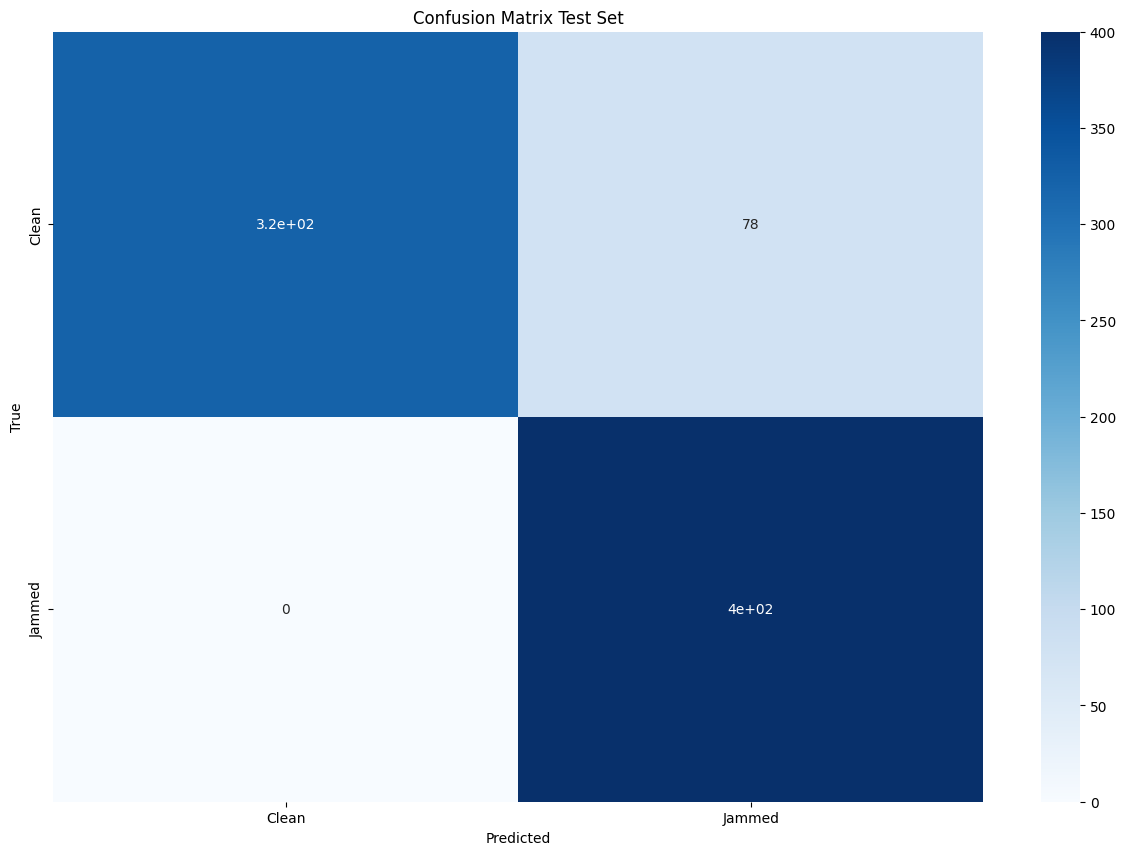

In [56]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold